In [1]:
import tensorflow as tf
import json
import gzip
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook

In [2]:
sess = None

In [3]:
def reset_tf(sess = None, log_device_placement = False):
    if sess:
        sess.close()
    tf.reset_default_graph()
    tf.set_random_seed(0)
    return tf.InteractiveSession(config = tf.ConfigProto(log_device_placement = log_device_placement))

In [4]:
class HyperParameters():
    # adam learning rate
    learning_rate = 1e-4

    # number of distinct terms (term indices are expected in 0..range(num_terms))
    vocab_size = 10000
    
    # number of dimensions in each layer
    layer_sizes = [1024]
#    layer_sizes = [512, 128]
    
    # dropout rate
    dropout_rate = 0.0
    
    # L2 regularizer scale
    l2_regularizer_scale = 0.0
    
    # number of sequences per batch
    pipeline_batch_size = 128
    
    # number of parsing threads in data pipeline
    pipeline_num_parallel_calls = 4
    
    # size of prefetch in data pipeline
    pipeline_prefetch_size = pipeline_batch_size * 16
    
    # shuffle buffer size
    pipeline_shuffle_size = 10000
    
    # prevents divide-by-zero/logarithm-of-zero
    epsilon = 1e-9
    
    # gradient clipping norm
    gradient_clip_norm = 5.0

hp = HyperParameters()

In [5]:
class AutoencoderModel:
    def __init__(self, session, hparams):
        self._session = session
        self._hparams = hparams
    
    def _parse_example(self, proto):
        # parse protobuf
        parsed = tf.parse_single_example(proto, features = {
            'page_id': tf.FixedLenFeature([1], dtype=tf.int64),
            'word_ids': tf.VarLenFeature(tf.int64),
            'word_tf_idfs': tf.VarLenFeature(tf.float32) })
        
        # convert sparse -> dense tensors
        page_id = parsed['page_id']
        word_ids = tf.sparse_tensor_to_dense(parsed['word_ids'])
        word_tf_idfs = tf.sparse_tensor_to_dense(parsed['word_tf_idfs'])
        page_tf_idfs = tf.sparse_to_dense(word_ids, [self._hparams.vocab_size], word_tf_idfs)
        page_tf_idfs = tf.cast(page_tf_idfs, tf.float32)
        
        return page_id, page_tf_idfs
    
    def _build_pipeline(self):
        # dataset placeholders
        self._dataset_filenames = tf.placeholder(
            tf.string,
            shape = [None],
            name = 'dataset_filenames')
        self._dataset_limit = tf.placeholder_with_default(
            tf.constant(-1, dtype = tf.int64),
            shape = [],
            name = 'dataset_limit')
        
        # dataset
        dataset = tf.data.TFRecordDataset(
            tf.random_shuffle(self._dataset_filenames),
            compression_type = 'GZIP')
        dataset = dataset.take(self._dataset_limit)
        dataset = dataset.map(
            self._parse_example,
            num_parallel_calls = self._hparams.pipeline_num_parallel_calls)
        dataset = dataset.shuffle(self._hparams.pipeline_shuffle_size)
        dataset = dataset.prefetch(self._hparams.pipeline_prefetch_size)
        dataset = dataset.batch(self._hparams.pipeline_batch_size)
        
        # iterator
        self._dataset_iterator = dataset.make_initializable_iterator()
        page_ids, page_tf_idfs = self._dataset_iterator.get_next()

        # data placeholders
        self._page_ids = tf.placeholder_with_default(
            page_ids,
            [None, 1],
            name = 'page_ids')
        self._page_tf_idfs = tf.placeholder_with_default(
            page_tf_idfs,
            [None, self._hparams.vocab_size],
            name = 'page_tf_idfs')

        # externally useful stats
        self._minibatch_size = tf.shape(self._page_ids)[0]

#     def _build_model(self):
#         # placeholders
#         self._training = tf.placeholder_with_default(False, [], 'training')
#
#         # regularizer
#         regularizer = tf.contrib.layers.l2_regularizer(self._hparams.l2_regularizer_scale)
#
#         # layer weights
#         kernel_weights = []
#         bias_weights = []
#         in_size = self._hparams.vocab_size
#         for i, out_size in enumerate(self._hparams.layer_sizes):
#             kernel_weights.append(tf.get_variable(
#                 "kernel_%d_%d" % (in_size, out_size),
#                 [in_size, out_size],
#                 regularizer = regularizer))
#             bias_weights.append(tf.get_variable(
#                 "bias_%d" % in_size,
#                 [1, in_size],
#                 regularizer = regularizer))
#             in_size = out_size
#         bias_weights.append(tf.get_variable(
#             "bias_%d" % self._hparams.layer_sizes[-1],
#             [1, self._hparams.layer_sizes[-1]]))
#
#         # encoding layers
#         layer = self._page_dists
#         for kernel, bias in zip(kernel_weights, bias_weights):
#             layer = tf.nn.relu(tf.matmul(layer + bias, kernel))
#        
#         # embedding bias
#         layer = layer + bias_weights[-1]
#        
#         # decoding layers
#         for kernel, bias in reversed(list(zip(kernel_weights, bias_weights))):
#             layer = tf.nn.relu(tf.matmul(layer, tf.transpose(kernel)) - bias)
#
#         # make normalized output
#         layer_norms = tf.norm(
#             layer,
#             ord = 1,
#             axis = -1,
#             keep_dims = True)
#         self._output_dists = layer / layer_norms
        
    def _build_model(self):
        # placeholders
        self._training = tf.placeholder_with_default(False, [], 'training')
       
        # regularizer
        regularizer = tf.contrib.layers.l2_regularizer(self._hparams.l2_regularizer_scale)

        # layer template
        def make_layer(layer, layer_size, include_residual, name):
            residual_layer = layer
            layer = tf.layers.dense(
                layer,
                layer_size,
                activation = tf.nn.relu,
                kernel_regularizer = regularizer,
                name = name)
            if include_residual:
                layer += residual_layer
            layer = tf.layers.batch_normalization(
                layer,
                training = self._training,
                name = name)
            layer = tf.layers.dropout(
                layer,
                rate = self._hparams.dropout_rate,
                training = self._training)
            return layer
       
        # encoding
        curr_layer = self._page_tf_idfs
        in_size = self._hparams.vocab_size
        for i, out_size in enumerate(self._hparams.layer_sizes):
            curr_layer = make_layer(
                curr_layer,
                out_size,
                include_residual = (in_size == out_size),
                name = 'encoding_%d' % i)
            in_size = out_size
            
        # normalize embedding layer
#         curr_layer = tf.nn.softmax(curr_layer)
           
        # decoding
        for i, out_size in enumerate(reversed(self._hparams.layer_sizes[:-1])):
            curr_layer = make_layer(
                curr_layer,
                out_size,
                include_residual = (in_size == out_size),
                name = 'decoding_%d' % i)
            in_size = out_size
           
        # output
        self._output_tf_idfs = tf.layers.dense(
            curr_layer,
            self._hparams.vocab_size,
            name = 'output')
    
    def _build_optimizer(self):
        # mean squared error losses
        mse_losses = tf.square(self._page_tf_idfs - self._output_tf_idfs)
        self._total_mse_loss = tf.reduce_sum(mse_losses)
        self._mean_mse_loss = self._total_mse_loss / tf.cast(self._minibatch_size, tf.float32)
        
        # L2 losses
        l2_losses = tf.sqrt(tf.reduce_sum(mse_losses, axis = -1))
        self._total_l2_loss = tf.reduce_sum(l2_losses)
        self._mean_l2_loss = self._total_l2_loss / tf.cast(self._minibatch_size, tf.float32)
        
        # full loss
        optimizer_loss = self._mean_mse_loss
        optimizer_loss += tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        # optimizer
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self._optimizer = tf.train.AdamOptimizer(
                learning_rate = self._hparams.learning_rate)
            
            # gradient clipping
            gradients, variables = zip(
                *self._optimizer.compute_gradients(optimizer_loss))
            gradients, _ = tf.clip_by_global_norm(
                gradients,
                self._hparams.gradient_clip_norm)

            # train op
            self._global_step = tf.Variable(
                0,
                name = 'global_step',
                trainable = False)
            self._train_op = self._optimizer.apply_gradients(
                zip(gradients, variables),
                global_step = self._global_step)
    
    def build_model(self):
        self._build_pipeline()
        self._build_model()
        self._build_optimizer()

    def dump_statistics(self):
        total_parameters = 0
        for variable in tf.trainable_variables():
            # shape is an array of tf.Dimension
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim.value
            print('parameters for "%s": %d' % (variable.name, variable_parameters))
            total_parameters += variable_parameters
        print('total parameters: %d' % total_parameters)

    def process(self,
                dataset_path,
                dataset_limit = -1,
                header = 'results',
                train = False,
                log_file = None):
        cum_mse_loss = 0
        cum_l2_loss  = 0
        cum_num_examples = 0
        
        dataset_files = sorted(['%s/%s' % (dataset_path, f) for f in os.listdir(dataset_path)])
        
        self._session.run(self._dataset_iterator.initializer, feed_dict={
            self._dataset_filenames: dataset_files,
            self._dataset_limit: dataset_limit })

        start = datetime.datetime.now()
        progress = tqdm_notebook(leave = False, desc = header)

        while True:
            try:
                (_,
                 total_mse_loss,
                 total_l2_loss,
                 minibatch_size) = self._session.run(
                    (self._train_op if train else (),
                     self._total_mse_loss,
                     self._total_l2_loss,
                     self._minibatch_size),
                    feed_dict = { self._training: train })
            except tf.errors.OutOfRangeError:
                break

            cum_mse_loss += total_mse_loss
            cum_l2_loss += total_l2_loss
            cum_num_examples += minibatch_size
            progress.update(minibatch_size)

        progress.close()
        finish = datetime.datetime.now()

        message = '%s: time=%s, step=%d, mse_loss=%g, l2_loss=%g' % (
            header,
            finish - start,
            tf.train.global_step(sess, self._global_step),
            cum_mse_loss / cum_num_examples,
            cum_l2_loss / cum_num_examples)
        print(message)
        if log_file:
            print(message, file = log_file)
            log_file.flush()

In [6]:
sess = reset_tf(sess)

model = AutoencoderModel(sess, HyperParameters())
model.build_model()
model.dump_statistics()

INFO:tensorflow:Scale of 0 disables regularizer.
parameters for "encoding_0/kernel:0": 10240000
parameters for "encoding_0/bias:0": 1024
parameters for "encoding_0/gamma:0": 1024
parameters for "encoding_0/beta:0": 1024
parameters for "output/kernel:0": 10240000
parameters for "output/bias:0": 10000
total parameters: 20493072


In [7]:
sess.run(tf.global_variables_initializer())

In [8]:
with open('../logs/simplewiki/mediawiki_model_autoencoder_1.log', 'wt') as f:
    for i in range(500):
        model.process(
            '../data/simplewiki/simplewiki-20171103.autoencoder_1.train',
            train = True,
            header = 'train %d' % i,
            log_file = f)
        model.process(
            '../data/simplewiki/simplewiki-20171103.autoencoder_1.dev',
            train = False,
            header = 'dev %d' % i,
            log_file = f)

HBox(children=(IntProgress(value=1, bar_style='info', description='train 0', max=1), HTML(value='')))

train 0: time=0:00:01.492184, step=74, mse_loss=26.3123, l2_loss=4.10126


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 0', max=1), HTML(value='')))

dev 0: time=0:00:00.048139, step=74, mse_loss=0.604067, l2_loss=0.71394


HBox(children=(IntProgress(value=1, bar_style='info', description='train 1', max=1), HTML(value='')))

train 1: time=0:00:01.229394, step=148, mse_loss=3.93385, l2_loss=1.31707


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 1', max=1), HTML(value='')))

dev 1: time=0:00:00.040625, step=148, mse_loss=0.596979, l2_loss=0.710442


HBox(children=(IntProgress(value=1, bar_style='info', description='train 2', max=1), HTML(value='')))

train 2: time=0:00:01.228993, step=222, mse_loss=1.24438, l2_loss=0.842664


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 2', max=1), HTML(value='')))

dev 2: time=0:00:00.041133, step=222, mse_loss=0.596881, l2_loss=0.710148


HBox(children=(IntProgress(value=1, bar_style='info', description='train 3', max=1), HTML(value='')))

train 3: time=0:00:01.231519, step=296, mse_loss=0.749059, l2_loss=0.740106


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 3', max=1), HTML(value='')))

dev 3: time=0:00:00.041797, step=296, mse_loss=0.600005, l2_loss=0.710821


HBox(children=(IntProgress(value=1, bar_style='info', description='train 4', max=1), HTML(value='')))

train 4: time=0:00:01.227420, step=370, mse_loss=0.647254, l2_loss=0.714175


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 4', max=1), HTML(value='')))

dev 4: time=0:00:00.041511, step=370, mse_loss=0.608048, l2_loss=0.712739


HBox(children=(IntProgress(value=1, bar_style='info', description='train 5', max=1), HTML(value='')))

train 5: time=0:00:01.229140, step=444, mse_loss=0.614331, l2_loss=0.705824


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 5', max=1), HTML(value='')))

dev 5: time=0:00:00.045089, step=444, mse_loss=0.62413, l2_loss=0.716407


HBox(children=(IntProgress(value=1, bar_style='info', description='train 6', max=1), HTML(value='')))

train 6: time=0:00:01.231194, step=518, mse_loss=0.598151, l2_loss=0.701606


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 6', max=1), HTML(value='')))

dev 6: time=0:00:00.040967, step=518, mse_loss=0.654346, l2_loss=0.722831


HBox(children=(IntProgress(value=1, bar_style='info', description='train 7', max=1), HTML(value='')))

train 7: time=0:00:01.232221, step=592, mse_loss=0.58686, l2_loss=0.699181


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 7', max=1), HTML(value='')))

dev 7: time=0:00:00.040270, step=592, mse_loss=0.704223, l2_loss=0.732416


HBox(children=(IntProgress(value=1, bar_style='info', description='train 8', max=1), HTML(value='')))

train 8: time=0:00:01.230428, step=666, mse_loss=0.582223, l2_loss=0.697875


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 8', max=1), HTML(value='')))

dev 8: time=0:00:00.040922, step=666, mse_loss=0.771824, l2_loss=0.744199


HBox(children=(IntProgress(value=1, bar_style='info', description='train 9', max=1), HTML(value='')))

train 9: time=0:00:01.225888, step=740, mse_loss=0.577535, l2_loss=0.696937


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 9', max=1), HTML(value='')))

dev 9: time=0:00:00.040956, step=740, mse_loss=0.845226, l2_loss=0.755548


HBox(children=(IntProgress(value=1, bar_style='info', description='train 10', max=1), HTML(value='')))

train 10: time=0:00:01.239228, step=814, mse_loss=0.575668, l2_loss=0.696377


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 10', max=1), HTML(value='')))

dev 10: time=0:00:00.041679, step=814, mse_loss=0.902703, l2_loss=0.763986


HBox(children=(IntProgress(value=1, bar_style='info', description='train 11', max=1), HTML(value='')))

train 11: time=0:00:01.230886, step=888, mse_loss=0.572108, l2_loss=0.695766


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 11', max=1), HTML(value='')))

dev 11: time=0:00:00.041124, step=888, mse_loss=0.93964, l2_loss=0.769226


HBox(children=(IntProgress(value=1, bar_style='info', description='train 12', max=1), HTML(value='')))

train 12: time=0:00:01.226170, step=962, mse_loss=0.571581, l2_loss=0.695502


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 12', max=1), HTML(value='')))

dev 12: time=0:00:00.041084, step=962, mse_loss=0.961915, l2_loss=0.772067


HBox(children=(IntProgress(value=1, bar_style='info', description='train 13', max=1), HTML(value='')))

train 13: time=0:00:01.233436, step=1036, mse_loss=0.567923, l2_loss=0.694954


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 13', max=1), HTML(value='')))

dev 13: time=0:00:00.040826, step=1036, mse_loss=0.970185, l2_loss=0.773319


HBox(children=(IntProgress(value=1, bar_style='info', description='train 14', max=1), HTML(value='')))

train 14: time=0:00:01.236235, step=1110, mse_loss=0.568403, l2_loss=0.694873


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 14', max=1), HTML(value='')))

dev 14: time=0:00:00.040680, step=1110, mse_loss=0.975503, l2_loss=0.773772


HBox(children=(IntProgress(value=1, bar_style='info', description='train 15', max=1), HTML(value='')))

train 15: time=0:00:01.233918, step=1184, mse_loss=0.565103, l2_loss=0.694353


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 15', max=1), HTML(value='')))

dev 15: time=0:00:00.050101, step=1184, mse_loss=0.976216, l2_loss=0.774018


HBox(children=(IntProgress(value=1, bar_style='info', description='train 16', max=1), HTML(value='')))

train 16: time=0:00:01.227603, step=1258, mse_loss=0.565842, l2_loss=0.694305


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 16', max=1), HTML(value='')))

dev 16: time=0:00:00.043765, step=1258, mse_loss=0.974689, l2_loss=0.773776


HBox(children=(IntProgress(value=1, bar_style='info', description='train 17', max=1), HTML(value='')))

train 17: time=0:00:01.231670, step=1332, mse_loss=0.562153, l2_loss=0.693735


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 17', max=1), HTML(value='')))

dev 17: time=0:00:00.041491, step=1332, mse_loss=0.976802, l2_loss=0.773967


HBox(children=(IntProgress(value=1, bar_style='info', description='train 18', max=1), HTML(value='')))

train 18: time=0:00:01.230391, step=1406, mse_loss=0.56344, l2_loss=0.693735


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 18', max=1), HTML(value='')))

dev 18: time=0:00:00.045990, step=1406, mse_loss=0.97273, l2_loss=0.773588


HBox(children=(IntProgress(value=1, bar_style='info', description='train 19', max=1), HTML(value='')))

train 19: time=0:00:01.229700, step=1480, mse_loss=0.558974, l2_loss=0.692951


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 19', max=1), HTML(value='')))

dev 19: time=0:00:00.040562, step=1480, mse_loss=0.976768, l2_loss=0.77389


HBox(children=(IntProgress(value=1, bar_style='info', description='train 20', max=1), HTML(value='')))

train 20: time=0:00:01.235911, step=1554, mse_loss=0.559971, l2_loss=0.692776


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 20', max=1), HTML(value='')))

dev 20: time=0:00:00.041235, step=1554, mse_loss=0.972796, l2_loss=0.773533


HBox(children=(IntProgress(value=1, bar_style='info', description='train 21', max=1), HTML(value='')))

train 21: time=0:00:01.231631, step=1628, mse_loss=0.555501, l2_loss=0.691904


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 21', max=1), HTML(value='')))

dev 21: time=0:00:00.041120, step=1628, mse_loss=0.976225, l2_loss=0.773909


HBox(children=(IntProgress(value=1, bar_style='info', description='train 22', max=1), HTML(value='')))

train 22: time=0:00:01.225790, step=1702, mse_loss=0.555977, l2_loss=0.691388


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 22', max=1), HTML(value='')))

dev 22: time=0:00:00.044678, step=1702, mse_loss=0.971965, l2_loss=0.773333


HBox(children=(IntProgress(value=1, bar_style='info', description='train 23', max=1), HTML(value='')))

train 23: time=0:00:01.238648, step=1776, mse_loss=0.549677, l2_loss=0.689481


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 23', max=1), HTML(value='')))

dev 23: time=0:00:00.040939, step=1776, mse_loss=0.970976, l2_loss=0.772781


HBox(children=(IntProgress(value=1, bar_style='info', description='train 24', max=1), HTML(value='')))

train 24: time=0:00:01.238247, step=1850, mse_loss=0.549514, l2_loss=0.688636


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 24', max=1), HTML(value='')))

dev 24: time=0:00:00.040327, step=1850, mse_loss=0.968465, l2_loss=0.771978


HBox(children=(IntProgress(value=1, bar_style='info', description='train 25', max=1), HTML(value='')))

train 25: time=0:00:01.234514, step=1924, mse_loss=0.54462, l2_loss=0.687454


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 25', max=1), HTML(value='')))

dev 25: time=0:00:00.041369, step=1924, mse_loss=0.967421, l2_loss=0.771768


HBox(children=(IntProgress(value=1, bar_style='info', description='train 26', max=1), HTML(value='')))

train 26: time=0:00:01.235159, step=1998, mse_loss=0.545151, l2_loss=0.687128


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 26', max=1), HTML(value='')))

dev 26: time=0:00:00.041159, step=1998, mse_loss=0.967195, l2_loss=0.77157


HBox(children=(IntProgress(value=1, bar_style='info', description='train 27', max=1), HTML(value='')))

train 27: time=0:00:01.228317, step=2072, mse_loss=0.541948, l2_loss=0.686302


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 27', max=1), HTML(value='')))

dev 27: time=0:00:00.040956, step=2072, mse_loss=0.964421, l2_loss=0.771217


HBox(children=(IntProgress(value=1, bar_style='info', description='train 28', max=1), HTML(value='')))

train 28: time=0:00:01.232456, step=2146, mse_loss=0.54243, l2_loss=0.685991


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 28', max=1), HTML(value='')))

dev 28: time=0:00:00.042383, step=2146, mse_loss=0.963903, l2_loss=0.771125


HBox(children=(IntProgress(value=1, bar_style='info', description='train 29', max=1), HTML(value='')))

train 29: time=0:00:01.235978, step=2220, mse_loss=0.539611, l2_loss=0.685275


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 29', max=1), HTML(value='')))

dev 29: time=0:00:00.041106, step=2220, mse_loss=0.960438, l2_loss=0.770603


HBox(children=(IntProgress(value=1, bar_style='info', description='train 30', max=1), HTML(value='')))

train 30: time=0:00:01.242631, step=2294, mse_loss=0.53987, l2_loss=0.68505


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 30', max=1), HTML(value='')))

dev 30: time=0:00:00.044005, step=2294, mse_loss=0.959586, l2_loss=0.770403


HBox(children=(IntProgress(value=1, bar_style='info', description='train 31', max=1), HTML(value='')))

train 31: time=0:00:01.227858, step=2368, mse_loss=0.537205, l2_loss=0.684325


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 31', max=1), HTML(value='')))

dev 31: time=0:00:00.041549, step=2368, mse_loss=0.957078, l2_loss=0.769986


HBox(children=(IntProgress(value=1, bar_style='info', description='train 32', max=1), HTML(value='')))

train 32: time=0:00:01.227289, step=2442, mse_loss=0.537278, l2_loss=0.684042


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 32', max=1), HTML(value='')))

dev 32: time=0:00:00.040700, step=2442, mse_loss=0.954448, l2_loss=0.769562


HBox(children=(IntProgress(value=1, bar_style='info', description='train 33', max=1), HTML(value='')))

train 33: time=0:00:01.232068, step=2516, mse_loss=0.534807, l2_loss=0.683381


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 33', max=1), HTML(value='')))

dev 33: time=0:00:00.042015, step=2516, mse_loss=0.954782, l2_loss=0.769664


HBox(children=(IntProgress(value=1, bar_style='info', description='train 34', max=1), HTML(value='')))

train 34: time=0:00:01.226650, step=2590, mse_loss=0.534924, l2_loss=0.683221


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 34', max=1), HTML(value='')))

dev 34: time=0:00:00.041295, step=2590, mse_loss=0.948871, l2_loss=0.768865


HBox(children=(IntProgress(value=1, bar_style='info', description='train 35', max=1), HTML(value='')))

train 35: time=0:00:01.229802, step=2664, mse_loss=0.533138, l2_loss=0.682724


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 35', max=1), HTML(value='')))

dev 35: time=0:00:00.041125, step=2664, mse_loss=0.950767, l2_loss=0.769095


HBox(children=(IntProgress(value=1, bar_style='info', description='train 36', max=1), HTML(value='')))

train 36: time=0:00:01.234123, step=2738, mse_loss=0.532863, l2_loss=0.682483


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 36', max=1), HTML(value='')))

dev 36: time=0:00:00.040793, step=2738, mse_loss=0.94389, l2_loss=0.768057


HBox(children=(IntProgress(value=1, bar_style='info', description='train 37', max=1), HTML(value='')))

train 37: time=0:00:01.241008, step=2812, mse_loss=0.531117, l2_loss=0.681974


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 37', max=1), HTML(value='')))

dev 37: time=0:00:00.040474, step=2812, mse_loss=0.944516, l2_loss=0.768085


HBox(children=(IntProgress(value=1, bar_style='info', description='train 38', max=1), HTML(value='')))

train 38: time=0:00:01.226978, step=2886, mse_loss=0.530418, l2_loss=0.68156


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 38', max=1), HTML(value='')))

dev 38: time=0:00:00.041397, step=2886, mse_loss=0.940249, l2_loss=0.766905


HBox(children=(IntProgress(value=1, bar_style='info', description='train 39', max=1), HTML(value='')))

train 39: time=0:00:01.233714, step=2960, mse_loss=0.528343, l2_loss=0.680773


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 39', max=1), HTML(value='')))

dev 39: time=0:00:00.040260, step=2960, mse_loss=0.936187, l2_loss=0.765799


HBox(children=(IntProgress(value=1, bar_style='info', description='train 40', max=1), HTML(value='')))

train 40: time=0:00:01.234644, step=3034, mse_loss=0.527006, l2_loss=0.680027


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 40', max=1), HTML(value='')))

dev 40: time=0:00:00.041310, step=3034, mse_loss=0.933459, l2_loss=0.764767


HBox(children=(IntProgress(value=1, bar_style='info', description='train 41', max=1), HTML(value='')))

train 41: time=0:00:01.240594, step=3108, mse_loss=0.525305, l2_loss=0.679277


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 41', max=1), HTML(value='')))

dev 41: time=0:00:00.041510, step=3108, mse_loss=0.929515, l2_loss=0.763784


HBox(children=(IntProgress(value=1, bar_style='info', description='train 42', max=1), HTML(value='')))

train 42: time=0:00:01.226973, step=3182, mse_loss=0.524152, l2_loss=0.678679


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 42', max=1), HTML(value='')))

dev 42: time=0:00:00.044227, step=3182, mse_loss=0.926202, l2_loss=0.763148


HBox(children=(IntProgress(value=1, bar_style='info', description='train 43', max=1), HTML(value='')))

train 43: time=0:00:01.233422, step=3256, mse_loss=0.522666, l2_loss=0.678063


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 43', max=1), HTML(value='')))

dev 43: time=0:00:00.050743, step=3256, mse_loss=0.923312, l2_loss=0.762243


HBox(children=(IntProgress(value=1, bar_style='info', description='train 44', max=1), HTML(value='')))

train 44: time=0:00:01.226306, step=3330, mse_loss=0.521291, l2_loss=0.677398


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 44', max=1), HTML(value='')))

dev 44: time=0:00:00.043318, step=3330, mse_loss=0.92105, l2_loss=0.76174


HBox(children=(IntProgress(value=1, bar_style='info', description='train 45', max=1), HTML(value='')))

train 45: time=0:00:01.235681, step=3404, mse_loss=0.519306, l2_loss=0.67652


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 45', max=1), HTML(value='')))

dev 45: time=0:00:00.040568, step=3404, mse_loss=0.915667, l2_loss=0.76067


HBox(children=(IntProgress(value=1, bar_style='info', description='train 46', max=1), HTML(value='')))

train 46: time=0:00:01.229415, step=3478, mse_loss=0.5176, l2_loss=0.675662


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 46', max=1), HTML(value='')))

dev 46: time=0:00:00.042313, step=3478, mse_loss=0.916825, l2_loss=0.760481


HBox(children=(IntProgress(value=1, bar_style='info', description='train 47', max=1), HTML(value='')))

train 47: time=0:00:01.239415, step=3552, mse_loss=0.516, l2_loss=0.674933


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 47', max=1), HTML(value='')))

dev 47: time=0:00:00.040865, step=3552, mse_loss=0.91139, l2_loss=0.759539


HBox(children=(IntProgress(value=1, bar_style='info', description='train 48', max=1), HTML(value='')))

train 48: time=0:00:01.228627, step=3626, mse_loss=0.514769, l2_loss=0.674328


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 48', max=1), HTML(value='')))

dev 48: time=0:00:00.041286, step=3626, mse_loss=0.911215, l2_loss=0.759395


HBox(children=(IntProgress(value=1, bar_style='info', description='train 49', max=1), HTML(value='')))

train 49: time=0:00:01.234516, step=3700, mse_loss=0.513646, l2_loss=0.673759


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 49', max=1), HTML(value='')))

dev 49: time=0:00:00.041194, step=3700, mse_loss=0.906821, l2_loss=0.758532


HBox(children=(IntProgress(value=1, bar_style='info', description='train 50', max=1), HTML(value='')))

train 50: time=0:00:01.232785, step=3774, mse_loss=0.512479, l2_loss=0.673173


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 50', max=1), HTML(value='')))

dev 50: time=0:00:00.044283, step=3774, mse_loss=0.903978, l2_loss=0.757828


HBox(children=(IntProgress(value=1, bar_style='info', description='train 51', max=1), HTML(value='')))

train 51: time=0:00:01.226024, step=3848, mse_loss=0.511472, l2_loss=0.672669


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 51', max=1), HTML(value='')))

dev 51: time=0:00:00.044275, step=3848, mse_loss=0.90047, l2_loss=0.75721


HBox(children=(IntProgress(value=1, bar_style='info', description='train 52', max=1), HTML(value='')))

train 52: time=0:00:01.233102, step=3922, mse_loss=0.510377, l2_loss=0.672138


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 52', max=1), HTML(value='')))

dev 52: time=0:00:00.041114, step=3922, mse_loss=0.895922, l2_loss=0.756054


HBox(children=(IntProgress(value=1, bar_style='info', description='train 53', max=1), HTML(value='')))

train 53: time=0:00:01.233071, step=3996, mse_loss=0.509393, l2_loss=0.671682


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 53', max=1), HTML(value='')))

dev 53: time=0:00:00.040938, step=3996, mse_loss=0.893034, l2_loss=0.755566


HBox(children=(IntProgress(value=1, bar_style='info', description='train 54', max=1), HTML(value='')))

train 54: time=0:00:01.230606, step=4070, mse_loss=0.508444, l2_loss=0.671183


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 54', max=1), HTML(value='')))

dev 54: time=0:00:00.040686, step=4070, mse_loss=0.889619, l2_loss=0.754648


HBox(children=(IntProgress(value=1, bar_style='info', description='train 55', max=1), HTML(value='')))

train 55: time=0:00:01.233538, step=4144, mse_loss=0.507219, l2_loss=0.670597


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 55', max=1), HTML(value='')))

dev 55: time=0:00:00.047302, step=4144, mse_loss=0.885215, l2_loss=0.753939


HBox(children=(IntProgress(value=1, bar_style='info', description='train 56', max=1), HTML(value='')))

train 56: time=0:00:01.236042, step=4218, mse_loss=0.50595, l2_loss=0.669957


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 56', max=1), HTML(value='')))

dev 56: time=0:00:00.041221, step=4218, mse_loss=0.884119, l2_loss=0.753344


HBox(children=(IntProgress(value=1, bar_style='info', description='train 57', max=1), HTML(value='')))

train 57: time=0:00:01.227975, step=4292, mse_loss=0.504909, l2_loss=0.669384


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 57', max=1), HTML(value='')))

dev 57: time=0:00:00.043780, step=4292, mse_loss=0.880698, l2_loss=0.752798


HBox(children=(IntProgress(value=1, bar_style='info', description='train 58', max=1), HTML(value='')))

train 58: time=0:00:01.229710, step=4366, mse_loss=0.503921, l2_loss=0.668871


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 58', max=1), HTML(value='')))

dev 58: time=0:00:00.040891, step=4366, mse_loss=0.877676, l2_loss=0.752252


HBox(children=(IntProgress(value=1, bar_style='info', description='train 59', max=1), HTML(value='')))

train 59: time=0:00:01.239066, step=4440, mse_loss=0.502927, l2_loss=0.668353


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 59', max=1), HTML(value='')))

dev 59: time=0:00:00.041216, step=4440, mse_loss=0.875835, l2_loss=0.751738


HBox(children=(IntProgress(value=1, bar_style='info', description='train 60', max=1), HTML(value='')))

train 60: time=0:00:01.240402, step=4514, mse_loss=0.501985, l2_loss=0.667842


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 60', max=1), HTML(value='')))

dev 60: time=0:00:00.043639, step=4514, mse_loss=0.873233, l2_loss=0.751361


HBox(children=(IntProgress(value=1, bar_style='info', description='train 61', max=1), HTML(value='')))

train 61: time=0:00:01.228282, step=4588, mse_loss=0.500953, l2_loss=0.667267


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 61', max=1), HTML(value='')))

dev 61: time=0:00:00.040955, step=4588, mse_loss=0.87098, l2_loss=0.750791


HBox(children=(IntProgress(value=1, bar_style='info', description='train 62', max=1), HTML(value='')))

train 62: time=0:00:01.233028, step=4662, mse_loss=0.49984, l2_loss=0.666645


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 62', max=1), HTML(value='')))

dev 62: time=0:00:00.041676, step=4662, mse_loss=0.866512, l2_loss=0.750188


HBox(children=(IntProgress(value=1, bar_style='info', description='train 63', max=1), HTML(value='')))

train 63: time=0:00:01.225800, step=4736, mse_loss=0.498634, l2_loss=0.665966


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 63', max=1), HTML(value='')))

dev 63: time=0:00:00.045679, step=4736, mse_loss=0.866578, l2_loss=0.749964


HBox(children=(IntProgress(value=1, bar_style='info', description='train 64', max=1), HTML(value='')))

train 64: time=0:00:01.231926, step=4810, mse_loss=0.497664, l2_loss=0.665368


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 64', max=1), HTML(value='')))

dev 64: time=0:00:00.041424, step=4810, mse_loss=0.862837, l2_loss=0.749389


HBox(children=(IntProgress(value=1, bar_style='info', description='train 65', max=1), HTML(value='')))

train 65: time=0:00:01.231856, step=4884, mse_loss=0.496653, l2_loss=0.66475


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 65', max=1), HTML(value='')))

dev 65: time=0:00:00.040349, step=4884, mse_loss=0.859471, l2_loss=0.748789


HBox(children=(IntProgress(value=1, bar_style='info', description='train 66', max=1), HTML(value='')))

train 66: time=0:00:01.232783, step=4958, mse_loss=0.495738, l2_loss=0.664181


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 66', max=1), HTML(value='')))

dev 66: time=0:00:00.040532, step=4958, mse_loss=0.856814, l2_loss=0.748344


HBox(children=(IntProgress(value=1, bar_style='info', description='train 67', max=1), HTML(value='')))

train 67: time=0:00:01.236991, step=5032, mse_loss=0.494528, l2_loss=0.663469


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 67', max=1), HTML(value='')))

dev 67: time=0:00:00.041584, step=5032, mse_loss=0.856189, l2_loss=0.748071


HBox(children=(IntProgress(value=1, bar_style='info', description='train 68', max=1), HTML(value='')))

train 68: time=0:00:01.232188, step=5106, mse_loss=0.493483, l2_loss=0.662817


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 68', max=1), HTML(value='')))

dev 68: time=0:00:00.041030, step=5106, mse_loss=0.851646, l2_loss=0.747364


HBox(children=(IntProgress(value=1, bar_style='info', description='train 69', max=1), HTML(value='')))

train 69: time=0:00:01.231617, step=5180, mse_loss=0.492513, l2_loss=0.662246


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 69', max=1), HTML(value='')))

dev 69: time=0:00:00.041001, step=5180, mse_loss=0.850389, l2_loss=0.747199


HBox(children=(IntProgress(value=1, bar_style='info', description='train 70', max=1), HTML(value='')))

train 70: time=0:00:01.222373, step=5254, mse_loss=0.491542, l2_loss=0.661665


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 70', max=1), HTML(value='')))

dev 70: time=0:00:00.041253, step=5254, mse_loss=0.847004, l2_loss=0.746368


HBox(children=(IntProgress(value=1, bar_style='info', description='train 71', max=1), HTML(value='')))

train 71: time=0:00:01.234543, step=5328, mse_loss=0.490771, l2_loss=0.661215


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 71', max=1), HTML(value='')))

dev 71: time=0:00:00.043756, step=5328, mse_loss=0.844287, l2_loss=0.746192


HBox(children=(IntProgress(value=1, bar_style='info', description='train 72', max=1), HTML(value='')))

train 72: time=0:00:01.228849, step=5402, mse_loss=0.489722, l2_loss=0.66062


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 72', max=1), HTML(value='')))

dev 72: time=0:00:00.043607, step=5402, mse_loss=0.841824, l2_loss=0.745518


HBox(children=(IntProgress(value=1, bar_style='info', description='train 73', max=1), HTML(value='')))

train 73: time=0:00:01.227210, step=5476, mse_loss=0.488739, l2_loss=0.660028


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 73', max=1), HTML(value='')))

dev 73: time=0:00:00.054910, step=5476, mse_loss=0.838319, l2_loss=0.745024


HBox(children=(IntProgress(value=1, bar_style='info', description='train 74', max=1), HTML(value='')))

train 74: time=0:00:01.228980, step=5550, mse_loss=0.487715, l2_loss=0.659445


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 74', max=1), HTML(value='')))

dev 74: time=0:00:00.040833, step=5550, mse_loss=0.838107, l2_loss=0.744787


HBox(children=(IntProgress(value=1, bar_style='info', description='train 75', max=1), HTML(value='')))

train 75: time=0:00:01.234168, step=5624, mse_loss=0.486703, l2_loss=0.658859


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 75', max=1), HTML(value='')))

dev 75: time=0:00:00.048272, step=5624, mse_loss=0.831708, l2_loss=0.743858


HBox(children=(IntProgress(value=1, bar_style='info', description='train 76', max=1), HTML(value='')))

train 76: time=0:00:01.234683, step=5698, mse_loss=0.485608, l2_loss=0.658233


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 76', max=1), HTML(value='')))

dev 76: time=0:00:00.040779, step=5698, mse_loss=0.833306, l2_loss=0.743878


HBox(children=(IntProgress(value=1, bar_style='info', description='train 77', max=1), HTML(value='')))

train 77: time=0:00:01.230742, step=5772, mse_loss=0.484465, l2_loss=0.657591


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 77', max=1), HTML(value='')))

dev 77: time=0:00:00.041828, step=5772, mse_loss=0.827474, l2_loss=0.743087


HBox(children=(IntProgress(value=1, bar_style='info', description='train 78', max=1), HTML(value='')))

train 78: time=0:00:01.233205, step=5846, mse_loss=0.483254, l2_loss=0.656885


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 78', max=1), HTML(value='')))

dev 78: time=0:00:00.041714, step=5846, mse_loss=0.828, l2_loss=0.742983


HBox(children=(IntProgress(value=1, bar_style='info', description='train 79', max=1), HTML(value='')))

train 79: time=0:00:01.236496, step=5920, mse_loss=0.482217, l2_loss=0.656234


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 79', max=1), HTML(value='')))

dev 79: time=0:00:00.041611, step=5920, mse_loss=0.824276, l2_loss=0.742381


HBox(children=(IntProgress(value=1, bar_style='info', description='train 80', max=1), HTML(value='')))

train 80: time=0:00:01.229320, step=5994, mse_loss=0.481249, l2_loss=0.655639


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 80', max=1), HTML(value='')))

dev 80: time=0:00:00.041052, step=5994, mse_loss=0.822301, l2_loss=0.741945


HBox(children=(IntProgress(value=1, bar_style='info', description='train 81', max=1), HTML(value='')))

train 81: time=0:00:01.235053, step=6068, mse_loss=0.480038, l2_loss=0.654969


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 81', max=1), HTML(value='')))

dev 81: time=0:00:00.040237, step=6068, mse_loss=0.821906, l2_loss=0.741708


HBox(children=(IntProgress(value=1, bar_style='info', description='train 82', max=1), HTML(value='')))

train 82: time=0:00:01.233849, step=6142, mse_loss=0.478911, l2_loss=0.654323


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 82', max=1), HTML(value='')))

dev 82: time=0:00:00.040613, step=6142, mse_loss=0.818002, l2_loss=0.741277


HBox(children=(IntProgress(value=1, bar_style='info', description='train 83', max=1), HTML(value='')))

train 83: time=0:00:01.227034, step=6216, mse_loss=0.477846, l2_loss=0.653676


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 83', max=1), HTML(value='')))

dev 83: time=0:00:00.040557, step=6216, mse_loss=0.816025, l2_loss=0.740564


HBox(children=(IntProgress(value=1, bar_style='info', description='train 84', max=1), HTML(value='')))

train 84: time=0:00:01.229375, step=6290, mse_loss=0.476773, l2_loss=0.653005


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 84', max=1), HTML(value='')))

dev 84: time=0:00:00.043688, step=6290, mse_loss=0.813062, l2_loss=0.74021


HBox(children=(IntProgress(value=1, bar_style='info', description='train 85', max=1), HTML(value='')))

train 85: time=0:00:01.227289, step=6364, mse_loss=0.475562, l2_loss=0.652268


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 85', max=1), HTML(value='')))

dev 85: time=0:00:00.041059, step=6364, mse_loss=0.811886, l2_loss=0.7398


HBox(children=(IntProgress(value=1, bar_style='info', description='train 86', max=1), HTML(value='')))

train 86: time=0:00:01.227152, step=6438, mse_loss=0.474409, l2_loss=0.651558


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 86', max=1), HTML(value='')))

dev 86: time=0:00:00.046268, step=6438, mse_loss=0.809269, l2_loss=0.739409


HBox(children=(IntProgress(value=1, bar_style='info', description='train 87', max=1), HTML(value='')))

train 87: time=0:00:01.234914, step=6512, mse_loss=0.473297, l2_loss=0.650832


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 87', max=1), HTML(value='')))

dev 87: time=0:00:00.040696, step=6512, mse_loss=0.80901, l2_loss=0.739249


HBox(children=(IntProgress(value=1, bar_style='info', description='train 88', max=1), HTML(value='')))

train 88: time=0:00:01.233481, step=6586, mse_loss=0.472285, l2_loss=0.65015


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 88', max=1), HTML(value='')))

dev 88: time=0:00:00.041214, step=6586, mse_loss=0.803303, l2_loss=0.738136


HBox(children=(IntProgress(value=1, bar_style='info', description='train 89', max=1), HTML(value='')))

train 89: time=0:00:01.231323, step=6660, mse_loss=0.471336, l2_loss=0.649521


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 89', max=1), HTML(value='')))

dev 89: time=0:00:00.040523, step=6660, mse_loss=0.804687, l2_loss=0.73847


HBox(children=(IntProgress(value=1, bar_style='info', description='train 90', max=1), HTML(value='')))

train 90: time=0:00:01.228000, step=6734, mse_loss=0.470346, l2_loss=0.648889


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 90', max=1), HTML(value='')))

dev 90: time=0:00:00.061650, step=6734, mse_loss=0.80054, l2_loss=0.737372


HBox(children=(IntProgress(value=1, bar_style='info', description='train 91', max=1), HTML(value='')))

train 91: time=0:00:01.232474, step=6808, mse_loss=0.469292, l2_loss=0.648169


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 91', max=1), HTML(value='')))

dev 91: time=0:00:00.040734, step=6808, mse_loss=0.799004, l2_loss=0.737163


HBox(children=(IntProgress(value=1, bar_style='info', description='train 92', max=1), HTML(value='')))

train 92: time=0:00:01.230701, step=6882, mse_loss=0.468262, l2_loss=0.64747


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 92', max=1), HTML(value='')))

dev 92: time=0:00:00.041139, step=6882, mse_loss=0.797521, l2_loss=0.736795


HBox(children=(IntProgress(value=1, bar_style='info', description='train 93', max=1), HTML(value='')))

train 93: time=0:00:01.238214, step=6956, mse_loss=0.467239, l2_loss=0.646788


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 93', max=1), HTML(value='')))

dev 93: time=0:00:00.042959, step=6956, mse_loss=0.796033, l2_loss=0.73622


HBox(children=(IntProgress(value=1, bar_style='info', description='train 94', max=1), HTML(value='')))

train 94: time=0:00:01.236991, step=7030, mse_loss=0.466097, l2_loss=0.646041


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 94', max=1), HTML(value='')))

dev 94: time=0:00:00.040113, step=7030, mse_loss=0.792874, l2_loss=0.735778


HBox(children=(IntProgress(value=1, bar_style='info', description='train 95', max=1), HTML(value='')))

train 95: time=0:00:01.227097, step=7104, mse_loss=0.465059, l2_loss=0.645331


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 95', max=1), HTML(value='')))

dev 95: time=0:00:00.042927, step=7104, mse_loss=0.793678, l2_loss=0.735795


HBox(children=(IntProgress(value=1, bar_style='info', description='train 96', max=1), HTML(value='')))

train 96: time=0:00:01.234373, step=7178, mse_loss=0.464154, l2_loss=0.644692


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 96', max=1), HTML(value='')))

dev 96: time=0:00:00.045445, step=7178, mse_loss=0.789992, l2_loss=0.735089


HBox(children=(IntProgress(value=1, bar_style='info', description='train 97', max=1), HTML(value='')))

train 97: time=0:00:01.226321, step=7252, mse_loss=0.463266, l2_loss=0.644066


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 97', max=1), HTML(value='')))

dev 97: time=0:00:00.040732, step=7252, mse_loss=0.788433, l2_loss=0.734826


HBox(children=(IntProgress(value=1, bar_style='info', description='train 98', max=1), HTML(value='')))

train 98: time=0:00:01.235067, step=7326, mse_loss=0.462209, l2_loss=0.643359


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 98', max=1), HTML(value='')))

dev 98: time=0:00:00.040566, step=7326, mse_loss=0.787217, l2_loss=0.734408


HBox(children=(IntProgress(value=1, bar_style='info', description='train 99', max=1), HTML(value='')))

train 99: time=0:00:01.230758, step=7400, mse_loss=0.461302, l2_loss=0.642738


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 99', max=1), HTML(value='')))

dev 99: time=0:00:00.044931, step=7400, mse_loss=0.784834, l2_loss=0.734018


HBox(children=(IntProgress(value=1, bar_style='info', description='train 100', max=1), HTML(value='')))

train 100: time=0:00:01.232320, step=7474, mse_loss=0.460349, l2_loss=0.642083


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 100', max=1), HTML(value='')))

dev 100: time=0:00:00.040904, step=7474, mse_loss=0.78383, l2_loss=0.73377


HBox(children=(IntProgress(value=1, bar_style='info', description='train 101', max=1), HTML(value='')))

train 101: time=0:00:01.232177, step=7548, mse_loss=0.459424, l2_loss=0.641453


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 101', max=1), HTML(value='')))

dev 101: time=0:00:00.040435, step=7548, mse_loss=0.782083, l2_loss=0.733521


HBox(children=(IntProgress(value=1, bar_style='info', description='train 102', max=1), HTML(value='')))

train 102: time=0:00:01.230868, step=7622, mse_loss=0.458486, l2_loss=0.640788


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 102', max=1), HTML(value='')))

dev 102: time=0:00:00.040735, step=7622, mse_loss=0.781279, l2_loss=0.733025


HBox(children=(IntProgress(value=1, bar_style='info', description='train 103', max=1), HTML(value='')))

train 103: time=0:00:01.234307, step=7696, mse_loss=0.45755, l2_loss=0.640139


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 103', max=1), HTML(value='')))

dev 103: time=0:00:00.041159, step=7696, mse_loss=0.777144, l2_loss=0.732527


HBox(children=(IntProgress(value=1, bar_style='info', description='train 104', max=1), HTML(value='')))

train 104: time=0:00:01.237173, step=7770, mse_loss=0.456741, l2_loss=0.639597


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 104', max=1), HTML(value='')))

dev 104: time=0:00:00.041011, step=7770, mse_loss=0.777469, l2_loss=0.732306


HBox(children=(IntProgress(value=1, bar_style='info', description='train 105', max=1), HTML(value='')))

train 105: time=0:00:01.234524, step=7844, mse_loss=0.455841, l2_loss=0.638967


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 105', max=1), HTML(value='')))

dev 105: time=0:00:00.040909, step=7844, mse_loss=0.774241, l2_loss=0.731765


HBox(children=(IntProgress(value=1, bar_style='info', description='train 106', max=1), HTML(value='')))

train 106: time=0:00:01.223765, step=7918, mse_loss=0.455021, l2_loss=0.638384


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 106', max=1), HTML(value='')))

dev 106: time=0:00:00.040939, step=7918, mse_loss=0.772148, l2_loss=0.731435


HBox(children=(IntProgress(value=1, bar_style='info', description='train 107', max=1), HTML(value='')))

train 107: time=0:00:01.229567, step=7992, mse_loss=0.454146, l2_loss=0.637771


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 107', max=1), HTML(value='')))

dev 107: time=0:00:00.043949, step=7992, mse_loss=0.770859, l2_loss=0.731073


HBox(children=(IntProgress(value=1, bar_style='info', description='train 108', max=1), HTML(value='')))

train 108: time=0:00:01.237167, step=8066, mse_loss=0.453163, l2_loss=0.637077


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 108', max=1), HTML(value='')))

dev 108: time=0:00:00.051978, step=8066, mse_loss=0.766578, l2_loss=0.730397


HBox(children=(IntProgress(value=1, bar_style='info', description='train 109', max=1), HTML(value='')))

train 109: time=0:00:01.230708, step=8140, mse_loss=0.452218, l2_loss=0.636426


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 109', max=1), HTML(value='')))

dev 109: time=0:00:00.048230, step=8140, mse_loss=0.767548, l2_loss=0.730467


HBox(children=(IntProgress(value=1, bar_style='info', description='train 110', max=1), HTML(value='')))

train 110: time=0:00:01.229282, step=8214, mse_loss=0.451348, l2_loss=0.635805


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 110', max=1), HTML(value='')))

dev 110: time=0:00:00.041166, step=8214, mse_loss=0.763524, l2_loss=0.729688


HBox(children=(IntProgress(value=1, bar_style='info', description='train 111', max=1), HTML(value='')))

train 111: time=0:00:01.239160, step=8288, mse_loss=0.450353, l2_loss=0.635099


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 111', max=1), HTML(value='')))

dev 111: time=0:00:00.040543, step=8288, mse_loss=0.762554, l2_loss=0.729336


HBox(children=(IntProgress(value=1, bar_style='info', description='train 112', max=1), HTML(value='')))

train 112: time=0:00:01.240340, step=8362, mse_loss=0.449411, l2_loss=0.634444


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 112', max=1), HTML(value='')))

dev 112: time=0:00:00.041456, step=8362, mse_loss=0.760942, l2_loss=0.729033


HBox(children=(IntProgress(value=1, bar_style='info', description='train 113', max=1), HTML(value='')))

train 113: time=0:00:01.234172, step=8436, mse_loss=0.448507, l2_loss=0.633818


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 113', max=1), HTML(value='')))

dev 113: time=0:00:00.046810, step=8436, mse_loss=0.759674, l2_loss=0.728861


HBox(children=(IntProgress(value=1, bar_style='info', description='train 114', max=1), HTML(value='')))

train 114: time=0:00:01.234410, step=8510, mse_loss=0.447572, l2_loss=0.633147


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 114', max=1), HTML(value='')))

dev 114: time=0:00:00.041409, step=8510, mse_loss=0.75737, l2_loss=0.728345


HBox(children=(IntProgress(value=1, bar_style='info', description='train 115', max=1), HTML(value='')))

train 115: time=0:00:01.229947, step=8584, mse_loss=0.446604, l2_loss=0.632427


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 115', max=1), HTML(value='')))

dev 115: time=0:00:00.041034, step=8584, mse_loss=0.755765, l2_loss=0.727942


HBox(children=(IntProgress(value=1, bar_style='info', description='train 116', max=1), HTML(value='')))

train 116: time=0:00:01.230142, step=8658, mse_loss=0.445654, l2_loss=0.631743


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 116', max=1), HTML(value='')))

dev 116: time=0:00:00.040880, step=8658, mse_loss=0.755485, l2_loss=0.727728


HBox(children=(IntProgress(value=1, bar_style='info', description='train 117', max=1), HTML(value='')))

train 117: time=0:00:01.231819, step=8732, mse_loss=0.444816, l2_loss=0.631142


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 117', max=1), HTML(value='')))

dev 117: time=0:00:00.041152, step=8732, mse_loss=0.752266, l2_loss=0.727283


HBox(children=(IntProgress(value=1, bar_style='info', description='train 118', max=1), HTML(value='')))

train 118: time=0:00:01.231464, step=8806, mse_loss=0.443988, l2_loss=0.63058


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 118', max=1), HTML(value='')))

dev 118: time=0:00:00.043605, step=8806, mse_loss=0.750668, l2_loss=0.726858


HBox(children=(IntProgress(value=1, bar_style='info', description='train 119', max=1), HTML(value='')))

train 119: time=0:00:01.236709, step=8880, mse_loss=0.443087, l2_loss=0.629952


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 119', max=1), HTML(value='')))

dev 119: time=0:00:00.041049, step=8880, mse_loss=0.750485, l2_loss=0.72675


HBox(children=(IntProgress(value=1, bar_style='info', description='train 120', max=1), HTML(value='')))

train 120: time=0:00:01.233670, step=8954, mse_loss=0.442203, l2_loss=0.62933


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 120', max=1), HTML(value='')))

dev 120: time=0:00:00.041985, step=8954, mse_loss=0.747432, l2_loss=0.726113


HBox(children=(IntProgress(value=1, bar_style='info', description='train 121', max=1), HTML(value='')))

train 121: time=0:00:01.231291, step=9028, mse_loss=0.441379, l2_loss=0.628756


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 121', max=1), HTML(value='')))

dev 121: time=0:00:00.044905, step=9028, mse_loss=0.745895, l2_loss=0.72575


HBox(children=(IntProgress(value=1, bar_style='info', description='train 122', max=1), HTML(value='')))

train 122: time=0:00:01.230867, step=9102, mse_loss=0.440704, l2_loss=0.628281


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 122', max=1), HTML(value='')))

dev 122: time=0:00:00.042009, step=9102, mse_loss=0.743194, l2_loss=0.725315


HBox(children=(IntProgress(value=1, bar_style='info', description='train 123', max=1), HTML(value='')))

train 123: time=0:00:01.227958, step=9176, mse_loss=0.439875, l2_loss=0.62768


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 123', max=1), HTML(value='')))

dev 123: time=0:00:00.041095, step=9176, mse_loss=0.743849, l2_loss=0.725307


HBox(children=(IntProgress(value=1, bar_style='info', description='train 124', max=1), HTML(value='')))

train 124: time=0:00:01.230516, step=9250, mse_loss=0.439037, l2_loss=0.627123


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 124', max=1), HTML(value='')))

dev 124: time=0:00:00.042928, step=9250, mse_loss=0.740865, l2_loss=0.724734


HBox(children=(IntProgress(value=1, bar_style='info', description='train 125', max=1), HTML(value='')))

train 125: time=0:00:01.230521, step=9324, mse_loss=0.43813, l2_loss=0.626479


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 125', max=1), HTML(value='')))

dev 125: time=0:00:00.040996, step=9324, mse_loss=0.739408, l2_loss=0.724376


HBox(children=(IntProgress(value=1, bar_style='info', description='train 126', max=1), HTML(value='')))

train 126: time=0:00:01.233540, step=9398, mse_loss=0.437342, l2_loss=0.625936


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 126', max=1), HTML(value='')))

dev 126: time=0:00:00.048655, step=9398, mse_loss=0.73693, l2_loss=0.723824


HBox(children=(IntProgress(value=1, bar_style='info', description='train 127', max=1), HTML(value='')))

train 127: time=0:00:01.239066, step=9472, mse_loss=0.436603, l2_loss=0.625403


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 127', max=1), HTML(value='')))

dev 127: time=0:00:00.040955, step=9472, mse_loss=0.73532, l2_loss=0.723403


HBox(children=(IntProgress(value=1, bar_style='info', description='train 128', max=1), HTML(value='')))

train 128: time=0:00:01.242126, step=9546, mse_loss=0.435844, l2_loss=0.624878


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 128', max=1), HTML(value='')))

dev 128: time=0:00:00.042384, step=9546, mse_loss=0.735014, l2_loss=0.723496


HBox(children=(IntProgress(value=1, bar_style='info', description='train 129', max=1), HTML(value='')))

train 129: time=0:00:01.228637, step=9620, mse_loss=0.435139, l2_loss=0.624381


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 129', max=1), HTML(value='')))

dev 129: time=0:00:00.040889, step=9620, mse_loss=0.732571, l2_loss=0.722858


HBox(children=(IntProgress(value=1, bar_style='info', description='train 130', max=1), HTML(value='')))

train 130: time=0:00:01.227468, step=9694, mse_loss=0.434325, l2_loss=0.623814


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 130', max=1), HTML(value='')))

dev 130: time=0:00:00.042725, step=9694, mse_loss=0.730286, l2_loss=0.722407


HBox(children=(IntProgress(value=1, bar_style='info', description='train 131', max=1), HTML(value='')))

train 131: time=0:00:01.233694, step=9768, mse_loss=0.433523, l2_loss=0.623258


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 131', max=1), HTML(value='')))

dev 131: time=0:00:00.041253, step=9768, mse_loss=0.72902, l2_loss=0.722154


HBox(children=(IntProgress(value=1, bar_style='info', description='train 132', max=1), HTML(value='')))

train 132: time=0:00:01.229978, step=9842, mse_loss=0.432656, l2_loss=0.622669


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 132', max=1), HTML(value='')))

dev 132: time=0:00:00.041117, step=9842, mse_loss=0.728085, l2_loss=0.721858


HBox(children=(IntProgress(value=1, bar_style='info', description='train 133', max=1), HTML(value='')))

train 133: time=0:00:01.233836, step=9916, mse_loss=0.431716, l2_loss=0.622018


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 133', max=1), HTML(value='')))

dev 133: time=0:00:00.041131, step=9916, mse_loss=0.726409, l2_loss=0.721649


HBox(children=(IntProgress(value=1, bar_style='info', description='train 134', max=1), HTML(value='')))

train 134: time=0:00:01.230200, step=9990, mse_loss=0.430899, l2_loss=0.621443


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 134', max=1), HTML(value='')))

dev 134: time=0:00:00.040548, step=9990, mse_loss=0.72412, l2_loss=0.721178


HBox(children=(IntProgress(value=1, bar_style='info', description='train 135', max=1), HTML(value='')))

train 135: time=0:00:01.234143, step=10064, mse_loss=0.430107, l2_loss=0.620868


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 135', max=1), HTML(value='')))

dev 135: time=0:00:00.042215, step=10064, mse_loss=0.724697, l2_loss=0.720857


HBox(children=(IntProgress(value=1, bar_style='info', description='train 136', max=1), HTML(value='')))

train 136: time=0:00:01.237631, step=10138, mse_loss=0.429357, l2_loss=0.620362


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 136', max=1), HTML(value='')))

dev 136: time=0:00:00.041087, step=10138, mse_loss=0.721793, l2_loss=0.720318


HBox(children=(IntProgress(value=1, bar_style='info', description='train 137', max=1), HTML(value='')))

train 137: time=0:00:01.234157, step=10212, mse_loss=0.42859, l2_loss=0.619845


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 137', max=1), HTML(value='')))

dev 137: time=0:00:00.042150, step=10212, mse_loss=0.722307, l2_loss=0.720343


HBox(children=(IntProgress(value=1, bar_style='info', description='train 138', max=1), HTML(value='')))

train 138: time=0:00:01.235636, step=10286, mse_loss=0.427712, l2_loss=0.619247


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 138', max=1), HTML(value='')))

dev 138: time=0:00:00.046855, step=10286, mse_loss=0.719248, l2_loss=0.719703


HBox(children=(IntProgress(value=1, bar_style='info', description='train 139', max=1), HTML(value='')))

train 139: time=0:00:01.231964, step=10360, mse_loss=0.426863, l2_loss=0.618634


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 139', max=1), HTML(value='')))

dev 139: time=0:00:00.041349, step=10360, mse_loss=0.719029, l2_loss=0.719554


HBox(children=(IntProgress(value=1, bar_style='info', description='train 140', max=1), HTML(value='')))

train 140: time=0:00:01.229127, step=10434, mse_loss=0.42604, l2_loss=0.618089


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 140', max=1), HTML(value='')))

dev 140: time=0:00:00.045176, step=10434, mse_loss=0.719451, l2_loss=0.719464


HBox(children=(IntProgress(value=1, bar_style='info', description='train 141', max=1), HTML(value='')))

train 141: time=0:00:01.235578, step=10508, mse_loss=0.425339, l2_loss=0.617594


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 141', max=1), HTML(value='')))

dev 141: time=0:00:00.040838, step=10508, mse_loss=0.716708, l2_loss=0.718896


HBox(children=(IntProgress(value=1, bar_style='info', description='train 142', max=1), HTML(value='')))

train 142: time=0:00:01.231276, step=10582, mse_loss=0.424606, l2_loss=0.617066


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 142', max=1), HTML(value='')))

dev 142: time=0:00:00.040958, step=10582, mse_loss=0.715232, l2_loss=0.718635


HBox(children=(IntProgress(value=1, bar_style='info', description='train 143', max=1), HTML(value='')))

train 143: time=0:00:01.230711, step=10656, mse_loss=0.423746, l2_loss=0.616471


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 143', max=1), HTML(value='')))

dev 143: time=0:00:00.040878, step=10656, mse_loss=0.714972, l2_loss=0.718544


HBox(children=(IntProgress(value=1, bar_style='info', description='train 144', max=1), HTML(value='')))

train 144: time=0:00:01.238584, step=10730, mse_loss=0.423023, l2_loss=0.615945


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 144', max=1), HTML(value='')))

dev 144: time=0:00:00.040835, step=10730, mse_loss=0.714098, l2_loss=0.718204


HBox(children=(IntProgress(value=1, bar_style='info', description='train 145', max=1), HTML(value='')))

train 145: time=0:00:01.243247, step=10804, mse_loss=0.422155, l2_loss=0.61531


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 145', max=1), HTML(value='')))

dev 145: time=0:00:00.042475, step=10804, mse_loss=0.71195, l2_loss=0.717567


HBox(children=(IntProgress(value=1, bar_style='info', description='train 146', max=1), HTML(value='')))

train 146: time=0:00:01.231508, step=10878, mse_loss=0.421425, l2_loss=0.61478


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 146', max=1), HTML(value='')))

dev 146: time=0:00:00.044138, step=10878, mse_loss=0.709853, l2_loss=0.717197


HBox(children=(IntProgress(value=1, bar_style='info', description='train 147', max=1), HTML(value='')))

train 147: time=0:00:01.225753, step=10952, mse_loss=0.420616, l2_loss=0.614225


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 147', max=1), HTML(value='')))

dev 147: time=0:00:00.041148, step=10952, mse_loss=0.708781, l2_loss=0.716763


HBox(children=(IntProgress(value=1, bar_style='info', description='train 148', max=1), HTML(value='')))

train 148: time=0:00:01.232966, step=11026, mse_loss=0.420042, l2_loss=0.613826


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 148', max=1), HTML(value='')))

dev 148: time=0:00:00.042641, step=11026, mse_loss=0.7077, l2_loss=0.716517


HBox(children=(IntProgress(value=1, bar_style='info', description='train 149', max=1), HTML(value='')))

train 149: time=0:00:01.240451, step=11100, mse_loss=0.419298, l2_loss=0.61336


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 149', max=1), HTML(value='')))

dev 149: time=0:00:00.041129, step=11100, mse_loss=0.708274, l2_loss=0.716499


HBox(children=(IntProgress(value=1, bar_style='info', description='train 150', max=1), HTML(value='')))

train 150: time=0:00:01.235933, step=11174, mse_loss=0.418667, l2_loss=0.612886


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 150', max=1), HTML(value='')))

dev 150: time=0:00:00.041032, step=11174, mse_loss=0.705331, l2_loss=0.715812


HBox(children=(IntProgress(value=1, bar_style='info', description='train 151', max=1), HTML(value='')))

train 151: time=0:00:01.231248, step=11248, mse_loss=0.417983, l2_loss=0.612419


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 151', max=1), HTML(value='')))

dev 151: time=0:00:00.041375, step=11248, mse_loss=0.704727, l2_loss=0.715692


HBox(children=(IntProgress(value=1, bar_style='info', description='train 152', max=1), HTML(value='')))

train 152: time=0:00:01.237583, step=11322, mse_loss=0.417249, l2_loss=0.61182


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 152', max=1), HTML(value='')))

dev 152: time=0:00:00.041039, step=11322, mse_loss=0.701803, l2_loss=0.715079


HBox(children=(IntProgress(value=1, bar_style='info', description='train 153', max=1), HTML(value='')))

train 153: time=0:00:01.231146, step=11396, mse_loss=0.416599, l2_loss=0.611336


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 153', max=1), HTML(value='')))

dev 153: time=0:00:00.041176, step=11396, mse_loss=0.703165, l2_loss=0.715332


HBox(children=(IntProgress(value=1, bar_style='info', description='train 154', max=1), HTML(value='')))

train 154: time=0:00:01.233850, step=11470, mse_loss=0.415842, l2_loss=0.610742


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 154', max=1), HTML(value='')))

dev 154: time=0:00:00.040907, step=11470, mse_loss=0.701935, l2_loss=0.714864


HBox(children=(IntProgress(value=1, bar_style='info', description='train 155', max=1), HTML(value='')))

train 155: time=0:00:01.227268, step=11544, mse_loss=0.415085, l2_loss=0.610228


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 155', max=1), HTML(value='')))

dev 155: time=0:00:00.042528, step=11544, mse_loss=0.699905, l2_loss=0.714557


HBox(children=(IntProgress(value=1, bar_style='info', description='train 156', max=1), HTML(value='')))

train 156: time=0:00:01.230219, step=11618, mse_loss=0.414408, l2_loss=0.609706


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 156', max=1), HTML(value='')))

dev 156: time=0:00:00.042037, step=11618, mse_loss=0.699553, l2_loss=0.714275


HBox(children=(IntProgress(value=1, bar_style='info', description='train 157', max=1), HTML(value='')))

train 157: time=0:00:01.228313, step=11692, mse_loss=0.413769, l2_loss=0.609258


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 157', max=1), HTML(value='')))

dev 157: time=0:00:00.044192, step=11692, mse_loss=0.699139, l2_loss=0.714076


HBox(children=(IntProgress(value=1, bar_style='info', description='train 158', max=1), HTML(value='')))

train 158: time=0:00:01.238924, step=11766, mse_loss=0.413271, l2_loss=0.608873


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 158', max=1), HTML(value='')))

dev 158: time=0:00:00.040610, step=11766, mse_loss=0.69793, l2_loss=0.713732


HBox(children=(IntProgress(value=1, bar_style='info', description='train 159', max=1), HTML(value='')))

train 159: time=0:00:01.233332, step=11840, mse_loss=0.4126, l2_loss=0.608427


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 159', max=1), HTML(value='')))

dev 159: time=0:00:00.040750, step=11840, mse_loss=0.697515, l2_loss=0.713531


HBox(children=(IntProgress(value=1, bar_style='info', description='train 160', max=1), HTML(value='')))

train 160: time=0:00:01.233205, step=11914, mse_loss=0.411992, l2_loss=0.607959


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 160', max=1), HTML(value='')))

dev 160: time=0:00:00.040804, step=11914, mse_loss=0.695582, l2_loss=0.713152


HBox(children=(IntProgress(value=1, bar_style='info', description='train 161', max=1), HTML(value='')))

train 161: time=0:00:01.231591, step=11988, mse_loss=0.41135, l2_loss=0.607511


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 161', max=1), HTML(value='')))

dev 161: time=0:00:00.040964, step=11988, mse_loss=0.695301, l2_loss=0.712968


HBox(children=(IntProgress(value=1, bar_style='info', description='train 162', max=1), HTML(value='')))

train 162: time=0:00:01.239152, step=12062, mse_loss=0.410785, l2_loss=0.607056


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 162', max=1), HTML(value='')))

dev 162: time=0:00:00.045729, step=12062, mse_loss=0.692907, l2_loss=0.712528


HBox(children=(IntProgress(value=1, bar_style='info', description='train 163', max=1), HTML(value='')))

train 163: time=0:00:01.231856, step=12136, mse_loss=0.410254, l2_loss=0.606706


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 163', max=1), HTML(value='')))

dev 163: time=0:00:00.118756, step=12136, mse_loss=0.693542, l2_loss=0.712562


HBox(children=(IntProgress(value=1, bar_style='info', description='train 164', max=1), HTML(value='')))

train 164: time=0:00:01.230140, step=12210, mse_loss=0.409706, l2_loss=0.606319


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 164', max=1), HTML(value='')))

dev 164: time=0:00:00.040818, step=12210, mse_loss=0.692176, l2_loss=0.712295


HBox(children=(IntProgress(value=1, bar_style='info', description='train 165', max=1), HTML(value='')))

train 165: time=0:00:01.230729, step=12284, mse_loss=0.409231, l2_loss=0.606001


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 165', max=1), HTML(value='')))

dev 165: time=0:00:00.041038, step=12284, mse_loss=0.690523, l2_loss=0.711879


HBox(children=(IntProgress(value=1, bar_style='info', description='train 166', max=1), HTML(value='')))

train 166: time=0:00:01.234946, step=12358, mse_loss=0.408599, l2_loss=0.605523


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 166', max=1), HTML(value='')))

dev 166: time=0:00:00.040595, step=12358, mse_loss=0.690613, l2_loss=0.711947


HBox(children=(IntProgress(value=1, bar_style='info', description='train 167', max=1), HTML(value='')))

train 167: time=0:00:01.223779, step=12432, mse_loss=0.408079, l2_loss=0.605182


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 167', max=1), HTML(value='')))

dev 167: time=0:00:00.041670, step=12432, mse_loss=0.689554, l2_loss=0.711804


HBox(children=(IntProgress(value=1, bar_style='info', description='train 168', max=1), HTML(value='')))

train 168: time=0:00:01.234600, step=12506, mse_loss=0.407503, l2_loss=0.60479


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 168', max=1), HTML(value='')))

dev 168: time=0:00:00.040829, step=12506, mse_loss=0.689511, l2_loss=0.711528


HBox(children=(IntProgress(value=1, bar_style='info', description='train 169', max=1), HTML(value='')))

train 169: time=0:00:01.233093, step=12580, mse_loss=0.407048, l2_loss=0.604452


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 169', max=1), HTML(value='')))

dev 169: time=0:00:00.041707, step=12580, mse_loss=0.687585, l2_loss=0.711119


HBox(children=(IntProgress(value=1, bar_style='info', description='train 170', max=1), HTML(value='')))

train 170: time=0:00:01.231696, step=12654, mse_loss=0.406507, l2_loss=0.60404


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 170', max=1), HTML(value='')))

dev 170: time=0:00:00.041217, step=12654, mse_loss=0.688496, l2_loss=0.711068


HBox(children=(IntProgress(value=1, bar_style='info', description='train 171', max=1), HTML(value='')))

train 171: time=0:00:01.234923, step=12728, mse_loss=0.405968, l2_loss=0.603625


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 171', max=1), HTML(value='')))

dev 171: time=0:00:00.050654, step=12728, mse_loss=0.685561, l2_loss=0.710456


HBox(children=(IntProgress(value=1, bar_style='info', description='train 172', max=1), HTML(value='')))

train 172: time=0:00:01.237842, step=12802, mse_loss=0.405174, l2_loss=0.603046


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 172', max=1), HTML(value='')))

dev 172: time=0:00:00.041311, step=12802, mse_loss=0.685757, l2_loss=0.710178


HBox(children=(IntProgress(value=1, bar_style='info', description='train 173', max=1), HTML(value='')))

train 173: time=0:00:01.229443, step=12876, mse_loss=0.404627, l2_loss=0.602527


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 173', max=1), HTML(value='')))

dev 173: time=0:00:00.041683, step=12876, mse_loss=0.686616, l2_loss=0.710238


HBox(children=(IntProgress(value=1, bar_style='info', description='train 174', max=1), HTML(value='')))

train 174: time=0:00:01.232381, step=12950, mse_loss=0.404111, l2_loss=0.602223


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 174', max=1), HTML(value='')))

dev 174: time=0:00:00.041158, step=12950, mse_loss=0.684292, l2_loss=0.709474


HBox(children=(IntProgress(value=1, bar_style='info', description='train 175', max=1), HTML(value='')))

train 175: time=0:00:01.237579, step=13024, mse_loss=0.403653, l2_loss=0.601814


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 175', max=1), HTML(value='')))

dev 175: time=0:00:00.041521, step=13024, mse_loss=0.684761, l2_loss=0.709662


HBox(children=(IntProgress(value=1, bar_style='info', description='train 176', max=1), HTML(value='')))

train 176: time=0:00:01.235244, step=13098, mse_loss=0.403109, l2_loss=0.601519


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 176', max=1), HTML(value='')))

dev 176: time=0:00:00.041457, step=13098, mse_loss=0.683291, l2_loss=0.709069


HBox(children=(IntProgress(value=1, bar_style='info', description='train 177', max=1), HTML(value='')))

train 177: time=0:00:01.232841, step=13172, mse_loss=0.402574, l2_loss=0.60108


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 177', max=1), HTML(value='')))

dev 177: time=0:00:00.040611, step=13172, mse_loss=0.683247, l2_loss=0.709015


HBox(children=(IntProgress(value=1, bar_style='info', description='train 178', max=1), HTML(value='')))

train 178: time=0:00:01.229657, step=13246, mse_loss=0.402007, l2_loss=0.600702


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 178', max=1), HTML(value='')))

dev 178: time=0:00:00.046363, step=13246, mse_loss=0.683026, l2_loss=0.709137


HBox(children=(IntProgress(value=1, bar_style='info', description='train 179', max=1), HTML(value='')))

train 179: time=0:00:01.232165, step=13320, mse_loss=0.401463, l2_loss=0.600228


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 179', max=1), HTML(value='')))

dev 179: time=0:00:00.041829, step=13320, mse_loss=0.682374, l2_loss=0.708661


HBox(children=(IntProgress(value=1, bar_style='info', description='train 180', max=1), HTML(value='')))

train 180: time=0:00:01.228457, step=13394, mse_loss=0.400941, l2_loss=0.599861


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 180', max=1), HTML(value='')))

dev 180: time=0:00:00.047615, step=13394, mse_loss=0.681824, l2_loss=0.708588


HBox(children=(IntProgress(value=1, bar_style='info', description='train 181', max=1), HTML(value='')))

train 181: time=0:00:01.230306, step=13468, mse_loss=0.400484, l2_loss=0.599458


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 181', max=1), HTML(value='')))

dev 181: time=0:00:00.040872, step=13468, mse_loss=0.679949, l2_loss=0.708004


HBox(children=(IntProgress(value=1, bar_style='info', description='train 182', max=1), HTML(value='')))

train 182: time=0:00:01.232223, step=13542, mse_loss=0.399919, l2_loss=0.59906


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 182', max=1), HTML(value='')))

dev 182: time=0:00:00.045793, step=13542, mse_loss=0.680455, l2_loss=0.708298


HBox(children=(IntProgress(value=1, bar_style='info', description='train 183', max=1), HTML(value='')))

train 183: time=0:00:01.232053, step=13616, mse_loss=0.399394, l2_loss=0.59864


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 183', max=1), HTML(value='')))

dev 183: time=0:00:00.041913, step=13616, mse_loss=0.679322, l2_loss=0.70769


HBox(children=(IntProgress(value=1, bar_style='info', description='train 184', max=1), HTML(value='')))

train 184: time=0:00:01.232503, step=13690, mse_loss=0.398814, l2_loss=0.598193


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 184', max=1), HTML(value='')))

dev 184: time=0:00:00.040930, step=13690, mse_loss=0.679359, l2_loss=0.707943


HBox(children=(IntProgress(value=1, bar_style='info', description='train 185', max=1), HTML(value='')))

train 185: time=0:00:01.241924, step=13764, mse_loss=0.398499, l2_loss=0.597992


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 185', max=1), HTML(value='')))

dev 185: time=0:00:00.041703, step=13764, mse_loss=0.678325, l2_loss=0.707679


HBox(children=(IntProgress(value=1, bar_style='info', description='train 186', max=1), HTML(value='')))

train 186: time=0:00:01.233429, step=13838, mse_loss=0.398089, l2_loss=0.597708


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 186', max=1), HTML(value='')))

dev 186: time=0:00:00.041901, step=13838, mse_loss=0.678312, l2_loss=0.707765


HBox(children=(IntProgress(value=1, bar_style='info', description='train 187', max=1), HTML(value='')))

train 187: time=0:00:01.230497, step=13912, mse_loss=0.397864, l2_loss=0.597594


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 187', max=1), HTML(value='')))

dev 187: time=0:00:00.041215, step=13912, mse_loss=0.677481, l2_loss=0.707417


HBox(children=(IntProgress(value=1, bar_style='info', description='train 188', max=1), HTML(value='')))

train 188: time=0:00:01.233290, step=13986, mse_loss=0.397415, l2_loss=0.597231


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 188', max=1), HTML(value='')))

dev 188: time=0:00:00.041431, step=13986, mse_loss=0.676555, l2_loss=0.707135


HBox(children=(IntProgress(value=1, bar_style='info', description='train 189', max=1), HTML(value='')))

train 189: time=0:00:01.236140, step=14060, mse_loss=0.397062, l2_loss=0.596939


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 189', max=1), HTML(value='')))

dev 189: time=0:00:00.042816, step=14060, mse_loss=0.675373, l2_loss=0.706741


HBox(children=(IntProgress(value=1, bar_style='info', description='train 190', max=1), HTML(value='')))

train 190: time=0:00:01.232344, step=14134, mse_loss=0.396558, l2_loss=0.596562


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 190', max=1), HTML(value='')))

dev 190: time=0:00:00.045878, step=14134, mse_loss=0.674545, l2_loss=0.706231


HBox(children=(IntProgress(value=1, bar_style='info', description='train 191', max=1), HTML(value='')))

train 191: time=0:00:01.232153, step=14208, mse_loss=0.396227, l2_loss=0.596296


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 191', max=1), HTML(value='')))

dev 191: time=0:00:00.041560, step=14208, mse_loss=0.673004, l2_loss=0.705957


HBox(children=(IntProgress(value=1, bar_style='info', description='train 192', max=1), HTML(value='')))

train 192: time=0:00:01.235352, step=14282, mse_loss=0.395761, l2_loss=0.595982


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 192', max=1), HTML(value='')))

dev 192: time=0:00:00.041451, step=14282, mse_loss=0.673289, l2_loss=0.705675


HBox(children=(IntProgress(value=1, bar_style='info', description='train 193', max=1), HTML(value='')))

train 193: time=0:00:01.234053, step=14356, mse_loss=0.395418, l2_loss=0.5957


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 193', max=1), HTML(value='')))

dev 193: time=0:00:00.042857, step=14356, mse_loss=0.672405, l2_loss=0.705782


HBox(children=(IntProgress(value=1, bar_style='info', description='train 194', max=1), HTML(value='')))

train 194: time=0:00:01.231873, step=14430, mse_loss=0.395072, l2_loss=0.595448


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 194', max=1), HTML(value='')))

dev 194: time=0:00:00.045623, step=14430, mse_loss=0.671521, l2_loss=0.705391


HBox(children=(IntProgress(value=1, bar_style='info', description='train 195', max=1), HTML(value='')))

train 195: time=0:00:01.229288, step=14504, mse_loss=0.394678, l2_loss=0.595104


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 195', max=1), HTML(value='')))

dev 195: time=0:00:00.041127, step=14504, mse_loss=0.671094, l2_loss=0.705407


HBox(children=(IntProgress(value=1, bar_style='info', description='train 196', max=1), HTML(value='')))

train 196: time=0:00:01.232396, step=14578, mse_loss=0.394518, l2_loss=0.594982


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 196', max=1), HTML(value='')))

dev 196: time=0:00:00.041806, step=14578, mse_loss=0.670153, l2_loss=0.70503


HBox(children=(IntProgress(value=1, bar_style='info', description='train 197', max=1), HTML(value='')))

train 197: time=0:00:01.231391, step=14652, mse_loss=0.394023, l2_loss=0.594642


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 197', max=1), HTML(value='')))

dev 197: time=0:00:00.041178, step=14652, mse_loss=0.670294, l2_loss=0.70521


HBox(children=(IntProgress(value=1, bar_style='info', description='train 198', max=1), HTML(value='')))

train 198: time=0:00:01.231110, step=14726, mse_loss=0.393696, l2_loss=0.594347


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 198', max=1), HTML(value='')))

dev 198: time=0:00:00.046427, step=14726, mse_loss=0.66948, l2_loss=0.704804


HBox(children=(IntProgress(value=1, bar_style='info', description='train 199', max=1), HTML(value='')))

train 199: time=0:00:01.229827, step=14800, mse_loss=0.393189, l2_loss=0.594


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 199', max=1), HTML(value='')))

dev 199: time=0:00:00.042254, step=14800, mse_loss=0.669494, l2_loss=0.704972


HBox(children=(IntProgress(value=1, bar_style='info', description='train 200', max=1), HTML(value='')))

train 200: time=0:00:01.235770, step=14874, mse_loss=0.392847, l2_loss=0.593681


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 200', max=1), HTML(value='')))

dev 200: time=0:00:00.041302, step=14874, mse_loss=0.668413, l2_loss=0.704512


HBox(children=(IntProgress(value=1, bar_style='info', description='train 201', max=1), HTML(value='')))

train 201: time=0:00:01.235661, step=14948, mse_loss=0.392573, l2_loss=0.593482


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 201', max=1), HTML(value='')))

dev 201: time=0:00:00.041486, step=14948, mse_loss=0.669992, l2_loss=0.704877


HBox(children=(IntProgress(value=1, bar_style='info', description='train 202', max=1), HTML(value='')))

train 202: time=0:00:01.231325, step=15022, mse_loss=0.392169, l2_loss=0.593139


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 202', max=1), HTML(value='')))

dev 202: time=0:00:00.045975, step=15022, mse_loss=0.669028, l2_loss=0.704455


HBox(children=(IntProgress(value=1, bar_style='info', description='train 203', max=1), HTML(value='')))

train 203: time=0:00:01.236097, step=15096, mse_loss=0.391886, l2_loss=0.592894


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 203', max=1), HTML(value='')))

dev 203: time=0:00:00.047906, step=15096, mse_loss=0.668462, l2_loss=0.704502


HBox(children=(IntProgress(value=1, bar_style='info', description='train 204', max=1), HTML(value='')))

train 204: time=0:00:01.226077, step=15170, mse_loss=0.391458, l2_loss=0.592617


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 204', max=1), HTML(value='')))

dev 204: time=0:00:00.041103, step=15170, mse_loss=0.669196, l2_loss=0.70436


HBox(children=(IntProgress(value=1, bar_style='info', description='train 205', max=1), HTML(value='')))

train 205: time=0:00:01.234849, step=15244, mse_loss=0.391222, l2_loss=0.592394


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 205', max=1), HTML(value='')))

dev 205: time=0:00:00.041009, step=15244, mse_loss=0.666131, l2_loss=0.704015


HBox(children=(IntProgress(value=1, bar_style='info', description='train 206', max=1), HTML(value='')))

train 206: time=0:00:01.233071, step=15318, mse_loss=0.390851, l2_loss=0.592199


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 206', max=1), HTML(value='')))

dev 206: time=0:00:00.042369, step=15318, mse_loss=0.667403, l2_loss=0.704078


HBox(children=(IntProgress(value=1, bar_style='info', description='train 207', max=1), HTML(value='')))

train 207: time=0:00:01.229988, step=15392, mse_loss=0.39058, l2_loss=0.591952


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 207', max=1), HTML(value='')))

dev 207: time=0:00:00.041277, step=15392, mse_loss=0.664927, l2_loss=0.703818


HBox(children=(IntProgress(value=1, bar_style='info', description='train 208', max=1), HTML(value='')))

train 208: time=0:00:01.228736, step=15466, mse_loss=0.390259, l2_loss=0.591816


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 208', max=1), HTML(value='')))

dev 208: time=0:00:00.043237, step=15466, mse_loss=0.665916, l2_loss=0.703912


HBox(children=(IntProgress(value=1, bar_style='info', description='train 209', max=1), HTML(value='')))

train 209: time=0:00:01.230267, step=15540, mse_loss=0.390009, l2_loss=0.591598


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 209', max=1), HTML(value='')))

dev 209: time=0:00:00.042466, step=15540, mse_loss=0.663821, l2_loss=0.70347


HBox(children=(IntProgress(value=1, bar_style='info', description='train 210', max=1), HTML(value='')))

train 210: time=0:00:01.233025, step=15614, mse_loss=0.389796, l2_loss=0.591494


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 210', max=1), HTML(value='')))

dev 210: time=0:00:00.041220, step=15614, mse_loss=0.664453, l2_loss=0.703338


HBox(children=(IntProgress(value=1, bar_style='info', description='train 211', max=1), HTML(value='')))

train 211: time=0:00:01.229864, step=15688, mse_loss=0.389495, l2_loss=0.591218


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 211', max=1), HTML(value='')))

dev 211: time=0:00:00.040738, step=15688, mse_loss=0.662815, l2_loss=0.702952


HBox(children=(IntProgress(value=1, bar_style='info', description='train 212', max=1), HTML(value='')))

train 212: time=0:00:01.236813, step=15762, mse_loss=0.389266, l2_loss=0.591061


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 212', max=1), HTML(value='')))

dev 212: time=0:00:00.050974, step=15762, mse_loss=0.662875, l2_loss=0.703032


HBox(children=(IntProgress(value=1, bar_style='info', description='train 213', max=1), HTML(value='')))

train 213: time=0:00:01.230898, step=15836, mse_loss=0.388814, l2_loss=0.590702


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 213', max=1), HTML(value='')))

dev 213: time=0:00:00.041206, step=15836, mse_loss=0.662158, l2_loss=0.70243


HBox(children=(IntProgress(value=1, bar_style='info', description='train 214', max=1), HTML(value='')))

train 214: time=0:00:01.226384, step=15910, mse_loss=0.388531, l2_loss=0.590463


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 214', max=1), HTML(value='')))

dev 214: time=0:00:00.047537, step=15910, mse_loss=0.66163, l2_loss=0.702524


HBox(children=(IntProgress(value=1, bar_style='info', description='train 215', max=1), HTML(value='')))

train 215: time=0:00:01.226650, step=15984, mse_loss=0.388118, l2_loss=0.59019


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 215', max=1), HTML(value='')))

dev 215: time=0:00:00.040700, step=15984, mse_loss=0.66219, l2_loss=0.702318


HBox(children=(IntProgress(value=1, bar_style='info', description='train 216', max=1), HTML(value='')))

train 216: time=0:00:01.231120, step=16058, mse_loss=0.387856, l2_loss=0.589944


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 216', max=1), HTML(value='')))

dev 216: time=0:00:00.041273, step=16058, mse_loss=0.661772, l2_loss=0.702324


HBox(children=(IntProgress(value=1, bar_style='info', description='train 217', max=1), HTML(value='')))

train 217: time=0:00:01.230369, step=16132, mse_loss=0.387647, l2_loss=0.589833


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 217', max=1), HTML(value='')))

dev 217: time=0:00:00.041805, step=16132, mse_loss=0.660868, l2_loss=0.701968


HBox(children=(IntProgress(value=1, bar_style='info', description='train 218', max=1), HTML(value='')))

train 218: time=0:00:01.231529, step=16206, mse_loss=0.38737, l2_loss=0.589565


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 218', max=1), HTML(value='')))

dev 218: time=0:00:00.040818, step=16206, mse_loss=0.659813, l2_loss=0.701871


HBox(children=(IntProgress(value=1, bar_style='info', description='train 219', max=1), HTML(value='')))

train 219: time=0:00:01.231633, step=16280, mse_loss=0.386995, l2_loss=0.589336


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 219', max=1), HTML(value='')))

dev 219: time=0:00:00.048540, step=16280, mse_loss=0.65959, l2_loss=0.701642


HBox(children=(IntProgress(value=1, bar_style='info', description='train 220', max=1), HTML(value='')))

train 220: time=0:00:01.232730, step=16354, mse_loss=0.386676, l2_loss=0.589038


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 220', max=1), HTML(value='')))

dev 220: time=0:00:00.042377, step=16354, mse_loss=0.659766, l2_loss=0.701877


HBox(children=(IntProgress(value=1, bar_style='info', description='train 221', max=1), HTML(value='')))

train 221: time=0:00:01.230330, step=16428, mse_loss=0.386266, l2_loss=0.588759


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 221', max=1), HTML(value='')))

dev 221: time=0:00:00.040476, step=16428, mse_loss=0.659839, l2_loss=0.701809


HBox(children=(IntProgress(value=1, bar_style='info', description='train 222', max=1), HTML(value='')))

train 222: time=0:00:01.226755, step=16502, mse_loss=0.385987, l2_loss=0.58847


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 222', max=1), HTML(value='')))

dev 222: time=0:00:00.041529, step=16502, mse_loss=0.658446, l2_loss=0.70149


HBox(children=(IntProgress(value=1, bar_style='info', description='train 223', max=1), HTML(value='')))

train 223: time=0:00:01.228121, step=16576, mse_loss=0.385647, l2_loss=0.588231


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 223', max=1), HTML(value='')))

dev 223: time=0:00:00.042379, step=16576, mse_loss=0.659438, l2_loss=0.701579


HBox(children=(IntProgress(value=1, bar_style='info', description='train 224', max=1), HTML(value='')))

train 224: time=0:00:01.229865, step=16650, mse_loss=0.385296, l2_loss=0.587917


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 224', max=1), HTML(value='')))

dev 224: time=0:00:00.043724, step=16650, mse_loss=0.658268, l2_loss=0.701308


HBox(children=(IntProgress(value=1, bar_style='info', description='train 225', max=1), HTML(value='')))

train 225: time=0:00:01.235916, step=16724, mse_loss=0.385135, l2_loss=0.587819


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 225', max=1), HTML(value='')))

dev 225: time=0:00:00.041045, step=16724, mse_loss=0.657626, l2_loss=0.701307


HBox(children=(IntProgress(value=1, bar_style='info', description='train 226', max=1), HTML(value='')))

train 226: time=0:00:01.237027, step=16798, mse_loss=0.384896, l2_loss=0.587663


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 226', max=1), HTML(value='')))

dev 226: time=0:00:00.040618, step=16798, mse_loss=0.657756, l2_loss=0.701209


HBox(children=(IntProgress(value=1, bar_style='info', description='train 227', max=1), HTML(value='')))

train 227: time=0:00:01.233583, step=16872, mse_loss=0.384741, l2_loss=0.58757


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 227', max=1), HTML(value='')))

dev 227: time=0:00:00.040842, step=16872, mse_loss=0.656082, l2_loss=0.700842


HBox(children=(IntProgress(value=1, bar_style='info', description='train 228', max=1), HTML(value='')))

train 228: time=0:00:01.232641, step=16946, mse_loss=0.384546, l2_loss=0.587444


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 228', max=1), HTML(value='')))

dev 228: time=0:00:00.041230, step=16946, mse_loss=0.655226, l2_loss=0.700718


HBox(children=(IntProgress(value=1, bar_style='info', description='train 229', max=1), HTML(value='')))

train 229: time=0:00:01.226466, step=17020, mse_loss=0.38421, l2_loss=0.587214


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 229', max=1), HTML(value='')))

dev 229: time=0:00:00.041882, step=17020, mse_loss=0.656078, l2_loss=0.700752


HBox(children=(IntProgress(value=1, bar_style='info', description='train 230', max=1), HTML(value='')))

train 230: time=0:00:01.231103, step=17094, mse_loss=0.383996, l2_loss=0.587006


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 230', max=1), HTML(value='')))

dev 230: time=0:00:00.041373, step=17094, mse_loss=0.653531, l2_loss=0.700069


HBox(children=(IntProgress(value=1, bar_style='info', description='train 231', max=1), HTML(value='')))

train 231: time=0:00:01.231977, step=17168, mse_loss=0.383743, l2_loss=0.586818


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 231', max=1), HTML(value='')))

dev 231: time=0:00:00.041494, step=17168, mse_loss=0.653922, l2_loss=0.699939


HBox(children=(IntProgress(value=1, bar_style='info', description='train 232', max=1), HTML(value='')))

train 232: time=0:00:01.238209, step=17242, mse_loss=0.383456, l2_loss=0.58657


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 232', max=1), HTML(value='')))

dev 232: time=0:00:00.041614, step=17242, mse_loss=0.65288, l2_loss=0.699537


HBox(children=(IntProgress(value=1, bar_style='info', description='train 233', max=1), HTML(value='')))

train 233: time=0:00:01.231743, step=17316, mse_loss=0.38314, l2_loss=0.586376


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 233', max=1), HTML(value='')))

dev 233: time=0:00:00.041085, step=17316, mse_loss=0.653364, l2_loss=0.699564


HBox(children=(IntProgress(value=1, bar_style='info', description='train 234', max=1), HTML(value='')))

train 234: time=0:00:01.233698, step=17390, mse_loss=0.382743, l2_loss=0.586049


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 234', max=1), HTML(value='')))

dev 234: time=0:00:00.040999, step=17390, mse_loss=0.653143, l2_loss=0.69956


HBox(children=(IntProgress(value=1, bar_style='info', description='train 235', max=1), HTML(value='')))

train 235: time=0:00:01.235712, step=17464, mse_loss=0.382359, l2_loss=0.585756


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 235', max=1), HTML(value='')))

dev 235: time=0:00:00.040842, step=17464, mse_loss=0.652164, l2_loss=0.69951


HBox(children=(IntProgress(value=1, bar_style='info', description='train 236', max=1), HTML(value='')))

train 236: time=0:00:01.246082, step=17538, mse_loss=0.382088, l2_loss=0.585521


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 236', max=1), HTML(value='')))

dev 236: time=0:00:00.041164, step=17538, mse_loss=0.651772, l2_loss=0.699297


HBox(children=(IntProgress(value=1, bar_style='info', description='train 237', max=1), HTML(value='')))

train 237: time=0:00:01.232541, step=17612, mse_loss=0.381764, l2_loss=0.585289


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 237', max=1), HTML(value='')))

dev 237: time=0:00:00.041793, step=17612, mse_loss=0.652369, l2_loss=0.69936


HBox(children=(IntProgress(value=1, bar_style='info', description='train 238', max=1), HTML(value='')))

train 238: time=0:00:01.230243, step=17686, mse_loss=0.381558, l2_loss=0.585131


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 238', max=1), HTML(value='')))

dev 238: time=0:00:00.042333, step=17686, mse_loss=0.651324, l2_loss=0.69901


HBox(children=(IntProgress(value=1, bar_style='info', description='train 239', max=1), HTML(value='')))

train 239: time=0:00:01.233055, step=17760, mse_loss=0.381435, l2_loss=0.58509


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 239', max=1), HTML(value='')))

dev 239: time=0:00:00.040761, step=17760, mse_loss=0.651477, l2_loss=0.699102


HBox(children=(IntProgress(value=1, bar_style='info', description='train 240', max=1), HTML(value='')))

train 240: time=0:00:01.223672, step=17834, mse_loss=0.381225, l2_loss=0.58497


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 240', max=1), HTML(value='')))

dev 240: time=0:00:00.040437, step=17834, mse_loss=0.65111, l2_loss=0.699094


HBox(children=(IntProgress(value=1, bar_style='info', description='train 241', max=1), HTML(value='')))

train 241: time=0:00:01.223659, step=17908, mse_loss=0.381066, l2_loss=0.584869


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 241', max=1), HTML(value='')))

dev 241: time=0:00:00.040917, step=17908, mse_loss=0.649672, l2_loss=0.698872


HBox(children=(IntProgress(value=1, bar_style='info', description='train 242', max=1), HTML(value='')))

train 242: time=0:00:01.225507, step=17982, mse_loss=0.380757, l2_loss=0.584652


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 242', max=1), HTML(value='')))

dev 242: time=0:00:00.048303, step=17982, mse_loss=0.649421, l2_loss=0.698653


HBox(children=(IntProgress(value=1, bar_style='info', description='train 243', max=1), HTML(value='')))

train 243: time=0:00:01.233211, step=18056, mse_loss=0.380519, l2_loss=0.584425


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 243', max=1), HTML(value='')))

dev 243: time=0:00:00.041068, step=18056, mse_loss=0.648452, l2_loss=0.698472


HBox(children=(IntProgress(value=1, bar_style='info', description='train 244', max=1), HTML(value='')))

train 244: time=0:00:01.231011, step=18130, mse_loss=0.380269, l2_loss=0.584274


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 244', max=1), HTML(value='')))

dev 244: time=0:00:00.042553, step=18130, mse_loss=0.648157, l2_loss=0.698443


HBox(children=(IntProgress(value=1, bar_style='info', description='train 245', max=1), HTML(value='')))

train 245: time=0:00:01.235796, step=18204, mse_loss=0.380047, l2_loss=0.584026


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 245', max=1), HTML(value='')))

dev 245: time=0:00:00.041582, step=18204, mse_loss=0.648099, l2_loss=0.698645


HBox(children=(IntProgress(value=1, bar_style='info', description='train 246', max=1), HTML(value='')))

train 246: time=0:00:01.236816, step=18278, mse_loss=0.379802, l2_loss=0.583874


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 246', max=1), HTML(value='')))

dev 246: time=0:00:00.040853, step=18278, mse_loss=0.649363, l2_loss=0.69889


HBox(children=(IntProgress(value=1, bar_style='info', description='train 247', max=1), HTML(value='')))

train 247: time=0:00:01.238888, step=18352, mse_loss=0.3796, l2_loss=0.583683


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 247', max=1), HTML(value='')))

dev 247: time=0:00:00.040734, step=18352, mse_loss=0.647386, l2_loss=0.698294


HBox(children=(IntProgress(value=1, bar_style='info', description='train 248', max=1), HTML(value='')))

train 248: time=0:00:01.232499, step=18426, mse_loss=0.379388, l2_loss=0.583576


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 248', max=1), HTML(value='')))

dev 248: time=0:00:00.040603, step=18426, mse_loss=0.647241, l2_loss=0.698161


HBox(children=(IntProgress(value=1, bar_style='info', description='train 249', max=1), HTML(value='')))

train 249: time=0:00:01.235121, step=18500, mse_loss=0.379153, l2_loss=0.583328


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 249', max=1), HTML(value='')))

dev 249: time=0:00:00.040566, step=18500, mse_loss=0.646633, l2_loss=0.697721


HBox(children=(IntProgress(value=1, bar_style='info', description='train 250', max=1), HTML(value='')))

train 250: time=0:00:01.230540, step=18574, mse_loss=0.378904, l2_loss=0.58318


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 250', max=1), HTML(value='')))

dev 250: time=0:00:00.048610, step=18574, mse_loss=0.646571, l2_loss=0.697827


HBox(children=(IntProgress(value=1, bar_style='info', description='train 251', max=1), HTML(value='')))

train 251: time=0:00:01.235176, step=18648, mse_loss=0.378682, l2_loss=0.582959


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 251', max=1), HTML(value='')))

dev 251: time=0:00:00.041350, step=18648, mse_loss=0.646382, l2_loss=0.697594


HBox(children=(IntProgress(value=1, bar_style='info', description='train 252', max=1), HTML(value='')))

train 252: time=0:00:01.231659, step=18722, mse_loss=0.378474, l2_loss=0.582809


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 252', max=1), HTML(value='')))

dev 252: time=0:00:00.041457, step=18722, mse_loss=0.645834, l2_loss=0.697509


HBox(children=(IntProgress(value=1, bar_style='info', description='train 253', max=1), HTML(value='')))

train 253: time=0:00:01.233859, step=18796, mse_loss=0.378211, l2_loss=0.58261


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 253', max=1), HTML(value='')))

dev 253: time=0:00:00.041841, step=18796, mse_loss=0.646056, l2_loss=0.697326


HBox(children=(IntProgress(value=1, bar_style='info', description='train 254', max=1), HTML(value='')))

train 254: time=0:00:01.230210, step=18870, mse_loss=0.377897, l2_loss=0.582338


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 254', max=1), HTML(value='')))

dev 254: time=0:00:00.041552, step=18870, mse_loss=0.64514, l2_loss=0.697226


HBox(children=(IntProgress(value=1, bar_style='info', description='train 255', max=1), HTML(value='')))

train 255: time=0:00:01.233041, step=18944, mse_loss=0.377651, l2_loss=0.582187


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 255', max=1), HTML(value='')))

dev 255: time=0:00:00.040920, step=18944, mse_loss=0.645687, l2_loss=0.69714


HBox(children=(IntProgress(value=1, bar_style='info', description='train 256', max=1), HTML(value='')))

train 256: time=0:00:01.229215, step=19018, mse_loss=0.37728, l2_loss=0.581812


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 256', max=1), HTML(value='')))

dev 256: time=0:00:00.041002, step=19018, mse_loss=0.644015, l2_loss=0.696867


HBox(children=(IntProgress(value=1, bar_style='info', description='train 257', max=1), HTML(value='')))

train 257: time=0:00:01.234600, step=19092, mse_loss=0.377072, l2_loss=0.581699


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 257', max=1), HTML(value='')))

dev 257: time=0:00:00.041025, step=19092, mse_loss=0.643941, l2_loss=0.696539


HBox(children=(IntProgress(value=1, bar_style='info', description='train 258', max=1), HTML(value='')))

train 258: time=0:00:01.226945, step=19166, mse_loss=0.376931, l2_loss=0.581524


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 258', max=1), HTML(value='')))

dev 258: time=0:00:00.041494, step=19166, mse_loss=0.643113, l2_loss=0.696502


HBox(children=(IntProgress(value=1, bar_style='info', description='train 259', max=1), HTML(value='')))

train 259: time=0:00:01.230404, step=19240, mse_loss=0.376733, l2_loss=0.581492


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 259', max=1), HTML(value='')))

dev 259: time=0:00:00.043754, step=19240, mse_loss=0.64178, l2_loss=0.69618


HBox(children=(IntProgress(value=1, bar_style='info', description='train 260', max=1), HTML(value='')))

train 260: time=0:00:01.234957, step=19314, mse_loss=0.376736, l2_loss=0.581446


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 260', max=1), HTML(value='')))

dev 260: time=0:00:00.040216, step=19314, mse_loss=0.642095, l2_loss=0.696389


HBox(children=(IntProgress(value=1, bar_style='info', description='train 261', max=1), HTML(value='')))

train 261: time=0:00:01.232629, step=19388, mse_loss=0.376415, l2_loss=0.581358


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 261', max=1), HTML(value='')))

dev 261: time=0:00:00.040934, step=19388, mse_loss=0.642291, l2_loss=0.696404


HBox(children=(IntProgress(value=1, bar_style='info', description='train 262', max=1), HTML(value='')))

train 262: time=0:00:01.239228, step=19462, mse_loss=0.376244, l2_loss=0.581154


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 262', max=1), HTML(value='')))

dev 262: time=0:00:00.041209, step=19462, mse_loss=0.641798, l2_loss=0.696275


HBox(children=(IntProgress(value=1, bar_style='info', description='train 263', max=1), HTML(value='')))

train 263: time=0:00:01.233464, step=19536, mse_loss=0.375962, l2_loss=0.581014


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 263', max=1), HTML(value='')))

dev 263: time=0:00:00.042079, step=19536, mse_loss=0.641204, l2_loss=0.696179


HBox(children=(IntProgress(value=1, bar_style='info', description='train 264', max=1), HTML(value='')))

train 264: time=0:00:01.231151, step=19610, mse_loss=0.375802, l2_loss=0.58083


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 264', max=1), HTML(value='')))

dev 264: time=0:00:00.045732, step=19610, mse_loss=0.642094, l2_loss=0.696087


HBox(children=(IntProgress(value=1, bar_style='info', description='train 265', max=1), HTML(value='')))

train 265: time=0:00:01.224248, step=19684, mse_loss=0.37566, l2_loss=0.580736


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 265', max=1), HTML(value='')))

dev 265: time=0:00:00.042042, step=19684, mse_loss=0.640241, l2_loss=0.695781


HBox(children=(IntProgress(value=1, bar_style='info', description='train 266', max=1), HTML(value='')))

train 266: time=0:00:01.238439, step=19758, mse_loss=0.375607, l2_loss=0.580692


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 266', max=1), HTML(value='')))

dev 266: time=0:00:00.041883, step=19758, mse_loss=0.641709, l2_loss=0.69596


HBox(children=(IntProgress(value=1, bar_style='info', description='train 267', max=1), HTML(value='')))

train 267: time=0:00:01.233559, step=19832, mse_loss=0.375359, l2_loss=0.580539


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 267', max=1), HTML(value='')))

dev 267: time=0:00:00.042440, step=19832, mse_loss=0.639543, l2_loss=0.695671


HBox(children=(IntProgress(value=1, bar_style='info', description='train 268', max=1), HTML(value='')))

train 268: time=0:00:01.232769, step=19906, mse_loss=0.375223, l2_loss=0.580434


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 268', max=1), HTML(value='')))

dev 268: time=0:00:00.045536, step=19906, mse_loss=0.641562, l2_loss=0.695923


HBox(children=(IntProgress(value=1, bar_style='info', description='train 269', max=1), HTML(value='')))

train 269: time=0:00:01.230789, step=19980, mse_loss=0.374878, l2_loss=0.580147


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 269', max=1), HTML(value='')))

dev 269: time=0:00:00.055048, step=19980, mse_loss=0.640323, l2_loss=0.695665


HBox(children=(IntProgress(value=1, bar_style='info', description='train 270', max=1), HTML(value='')))

train 270: time=0:00:01.235591, step=20054, mse_loss=0.374614, l2_loss=0.579889


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 270', max=1), HTML(value='')))

dev 270: time=0:00:00.041017, step=20054, mse_loss=0.640207, l2_loss=0.695562


HBox(children=(IntProgress(value=1, bar_style='info', description='train 271', max=1), HTML(value='')))

train 271: time=0:00:01.232202, step=20128, mse_loss=0.37428, l2_loss=0.579614


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 271', max=1), HTML(value='')))

dev 271: time=0:00:00.041529, step=20128, mse_loss=0.638605, l2_loss=0.695235


HBox(children=(IntProgress(value=1, bar_style='info', description='train 272', max=1), HTML(value='')))

train 272: time=0:00:01.236314, step=20202, mse_loss=0.374062, l2_loss=0.57938


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 272', max=1), HTML(value='')))

dev 272: time=0:00:00.040971, step=20202, mse_loss=0.639469, l2_loss=0.695296


HBox(children=(IntProgress(value=1, bar_style='info', description='train 273', max=1), HTML(value='')))

train 273: time=0:00:01.236370, step=20276, mse_loss=0.373764, l2_loss=0.579136


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 273', max=1), HTML(value='')))

dev 273: time=0:00:00.040592, step=20276, mse_loss=0.636353, l2_loss=0.694505


HBox(children=(IntProgress(value=1, bar_style='info', description='train 274', max=1), HTML(value='')))

train 274: time=0:00:01.232157, step=20350, mse_loss=0.373676, l2_loss=0.579093


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 274', max=1), HTML(value='')))

dev 274: time=0:00:00.040230, step=20350, mse_loss=0.637738, l2_loss=0.694663


HBox(children=(IntProgress(value=1, bar_style='info', description='train 275', max=1), HTML(value='')))

train 275: time=0:00:01.230486, step=20424, mse_loss=0.373408, l2_loss=0.578941


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 275', max=1), HTML(value='')))

dev 275: time=0:00:00.049434, step=20424, mse_loss=0.63768, l2_loss=0.694565


HBox(children=(IntProgress(value=1, bar_style='info', description='train 276', max=1), HTML(value='')))

train 276: time=0:00:01.231254, step=20498, mse_loss=0.373301, l2_loss=0.578856


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 276', max=1), HTML(value='')))

dev 276: time=0:00:00.041052, step=20498, mse_loss=0.636213, l2_loss=0.694271


HBox(children=(IntProgress(value=1, bar_style='info', description='train 277', max=1), HTML(value='')))

train 277: time=0:00:01.229373, step=20572, mse_loss=0.37317, l2_loss=0.57881


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 277', max=1), HTML(value='')))

dev 277: time=0:00:00.041014, step=20572, mse_loss=0.636412, l2_loss=0.694333


HBox(children=(IntProgress(value=1, bar_style='info', description='train 278', max=1), HTML(value='')))

train 278: time=0:00:01.227684, step=20646, mse_loss=0.372954, l2_loss=0.578658


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 278', max=1), HTML(value='')))

dev 278: time=0:00:00.046532, step=20646, mse_loss=0.636653, l2_loss=0.694155


HBox(children=(IntProgress(value=1, bar_style='info', description='train 279', max=1), HTML(value='')))

train 279: time=0:00:01.228837, step=20720, mse_loss=0.37281, l2_loss=0.578586


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 279', max=1), HTML(value='')))

dev 279: time=0:00:00.041460, step=20720, mse_loss=0.634734, l2_loss=0.693841


HBox(children=(IntProgress(value=1, bar_style='info', description='train 280', max=1), HTML(value='')))

train 280: time=0:00:01.236111, step=20794, mse_loss=0.372606, l2_loss=0.578404


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 280', max=1), HTML(value='')))

dev 280: time=0:00:00.041654, step=20794, mse_loss=0.635916, l2_loss=0.693892


HBox(children=(IntProgress(value=1, bar_style='info', description='train 281', max=1), HTML(value='')))

train 281: time=0:00:01.226328, step=20868, mse_loss=0.37248, l2_loss=0.578329


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 281', max=1), HTML(value='')))

dev 281: time=0:00:00.040974, step=20868, mse_loss=0.635784, l2_loss=0.69393


HBox(children=(IntProgress(value=1, bar_style='info', description='train 282', max=1), HTML(value='')))

train 282: time=0:00:01.235184, step=20942, mse_loss=0.372238, l2_loss=0.5781


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 282', max=1), HTML(value='')))

dev 282: time=0:00:00.041009, step=20942, mse_loss=0.63588, l2_loss=0.693933


HBox(children=(IntProgress(value=1, bar_style='info', description='train 283', max=1), HTML(value='')))

train 283: time=0:00:01.229410, step=21016, mse_loss=0.372216, l2_loss=0.578103


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 283', max=1), HTML(value='')))

dev 283: time=0:00:00.043973, step=21016, mse_loss=0.635301, l2_loss=0.693931


HBox(children=(IntProgress(value=1, bar_style='info', description='train 284', max=1), HTML(value='')))

train 284: time=0:00:01.231728, step=21090, mse_loss=0.371967, l2_loss=0.577902


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 284', max=1), HTML(value='')))

dev 284: time=0:00:00.043542, step=21090, mse_loss=0.63492, l2_loss=0.693613


HBox(children=(IntProgress(value=1, bar_style='info', description='train 285', max=1), HTML(value='')))

train 285: time=0:00:01.228560, step=21164, mse_loss=0.371914, l2_loss=0.577832


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 285', max=1), HTML(value='')))

dev 285: time=0:00:00.040866, step=21164, mse_loss=0.635187, l2_loss=0.693644


HBox(children=(IntProgress(value=1, bar_style='info', description='train 286', max=1), HTML(value='')))

train 286: time=0:00:01.229406, step=21238, mse_loss=0.371546, l2_loss=0.577573


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 286', max=1), HTML(value='')))

dev 286: time=0:00:00.040904, step=21238, mse_loss=0.63527, l2_loss=0.693589


HBox(children=(IntProgress(value=1, bar_style='info', description='train 287', max=1), HTML(value='')))

train 287: time=0:00:01.225178, step=21312, mse_loss=0.371466, l2_loss=0.577511


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 287', max=1), HTML(value='')))

dev 287: time=0:00:00.042777, step=21312, mse_loss=0.633103, l2_loss=0.692913


HBox(children=(IntProgress(value=1, bar_style='info', description='train 288', max=1), HTML(value='')))

train 288: time=0:00:01.236363, step=21386, mse_loss=0.371283, l2_loss=0.577373


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 288', max=1), HTML(value='')))

dev 288: time=0:00:00.043562, step=21386, mse_loss=0.634361, l2_loss=0.693379


HBox(children=(IntProgress(value=1, bar_style='info', description='train 289', max=1), HTML(value='')))

train 289: time=0:00:01.229474, step=21460, mse_loss=0.371111, l2_loss=0.577245


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 289', max=1), HTML(value='')))

dev 289: time=0:00:00.040771, step=21460, mse_loss=0.633217, l2_loss=0.693029


HBox(children=(IntProgress(value=1, bar_style='info', description='train 290', max=1), HTML(value='')))

train 290: time=0:00:01.227979, step=21534, mse_loss=0.370895, l2_loss=0.577057


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 290', max=1), HTML(value='')))

dev 290: time=0:00:00.040703, step=21534, mse_loss=0.632256, l2_loss=0.692871


HBox(children=(IntProgress(value=1, bar_style='info', description='train 291', max=1), HTML(value='')))

train 291: time=0:00:01.227913, step=21608, mse_loss=0.370661, l2_loss=0.576815


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 291', max=1), HTML(value='')))

dev 291: time=0:00:00.041062, step=21608, mse_loss=0.634419, l2_loss=0.693223


HBox(children=(IntProgress(value=1, bar_style='info', description='train 292', max=1), HTML(value='')))

train 292: time=0:00:01.226462, step=21682, mse_loss=0.370364, l2_loss=0.57662


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 292', max=1), HTML(value='')))

dev 292: time=0:00:00.048698, step=21682, mse_loss=0.632363, l2_loss=0.692927


HBox(children=(IntProgress(value=1, bar_style='info', description='train 293', max=1), HTML(value='')))

train 293: time=0:00:01.226952, step=21756, mse_loss=0.370295, l2_loss=0.57653


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 293', max=1), HTML(value='')))

dev 293: time=0:00:00.040641, step=21756, mse_loss=0.632278, l2_loss=0.692622


HBox(children=(IntProgress(value=1, bar_style='info', description='train 294', max=1), HTML(value='')))

train 294: time=0:00:01.231887, step=21830, mse_loss=0.370054, l2_loss=0.576406


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 294', max=1), HTML(value='')))

dev 294: time=0:00:00.042093, step=21830, mse_loss=0.632703, l2_loss=0.692973


HBox(children=(IntProgress(value=1, bar_style='info', description='train 295', max=1), HTML(value='')))

train 295: time=0:00:01.235285, step=21904, mse_loss=0.369964, l2_loss=0.576271


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 295', max=1), HTML(value='')))

dev 295: time=0:00:00.042164, step=21904, mse_loss=0.63248, l2_loss=0.692669


HBox(children=(IntProgress(value=1, bar_style='info', description='train 296', max=1), HTML(value='')))

train 296: time=0:00:01.233987, step=21978, mse_loss=0.369781, l2_loss=0.576208


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 296', max=1), HTML(value='')))

dev 296: time=0:00:00.040863, step=21978, mse_loss=0.631546, l2_loss=0.692859


HBox(children=(IntProgress(value=1, bar_style='info', description='train 297', max=1), HTML(value='')))

train 297: time=0:00:01.236710, step=22052, mse_loss=0.369623, l2_loss=0.576044


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 297', max=1), HTML(value='')))

dev 297: time=0:00:00.041359, step=22052, mse_loss=0.6319, l2_loss=0.692645


HBox(children=(IntProgress(value=1, bar_style='info', description='train 298', max=1), HTML(value='')))

train 298: time=0:00:01.235177, step=22126, mse_loss=0.369402, l2_loss=0.575904


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 298', max=1), HTML(value='')))

dev 298: time=0:00:00.046331, step=22126, mse_loss=0.632361, l2_loss=0.692813


HBox(children=(IntProgress(value=1, bar_style='info', description='train 299', max=1), HTML(value='')))

train 299: time=0:00:01.231971, step=22200, mse_loss=0.369303, l2_loss=0.575836


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 299', max=1), HTML(value='')))

dev 299: time=0:00:00.040565, step=22200, mse_loss=0.630884, l2_loss=0.692035


HBox(children=(IntProgress(value=1, bar_style='info', description='train 300', max=1), HTML(value='')))

train 300: time=0:00:01.228365, step=22274, mse_loss=0.369116, l2_loss=0.575677


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 300', max=1), HTML(value='')))

dev 300: time=0:00:00.040990, step=22274, mse_loss=0.631325, l2_loss=0.692347


HBox(children=(IntProgress(value=1, bar_style='info', description='train 301', max=1), HTML(value='')))

train 301: time=0:00:01.229679, step=22348, mse_loss=0.369028, l2_loss=0.575646


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 301', max=1), HTML(value='')))

dev 301: time=0:00:00.041089, step=22348, mse_loss=0.629352, l2_loss=0.691571


HBox(children=(IntProgress(value=1, bar_style='info', description='train 302', max=1), HTML(value='')))

train 302: time=0:00:01.234089, step=22422, mse_loss=0.368929, l2_loss=0.575481


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 302', max=1), HTML(value='')))

dev 302: time=0:00:00.041109, step=22422, mse_loss=0.629775, l2_loss=0.691879


HBox(children=(IntProgress(value=1, bar_style='info', description='train 303', max=1), HTML(value='')))

train 303: time=0:00:01.230207, step=22496, mse_loss=0.368715, l2_loss=0.575371


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 303', max=1), HTML(value='')))

dev 303: time=0:00:00.045055, step=22496, mse_loss=0.63003, l2_loss=0.691834


HBox(children=(IntProgress(value=1, bar_style='info', description='train 304', max=1), HTML(value='')))

train 304: time=0:00:01.233046, step=22570, mse_loss=0.36869, l2_loss=0.575265


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 304', max=1), HTML(value='')))

dev 304: time=0:00:00.040685, step=22570, mse_loss=0.628852, l2_loss=0.691657


HBox(children=(IntProgress(value=1, bar_style='info', description='train 305', max=1), HTML(value='')))

train 305: time=0:00:01.232591, step=22644, mse_loss=0.368307, l2_loss=0.575041


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 305', max=1), HTML(value='')))

dev 305: time=0:00:00.040759, step=22644, mse_loss=0.628447, l2_loss=0.691551


HBox(children=(IntProgress(value=1, bar_style='info', description='train 306', max=1), HTML(value='')))

train 306: time=0:00:01.225003, step=22718, mse_loss=0.368252, l2_loss=0.574906


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 306', max=1), HTML(value='')))

dev 306: time=0:00:00.040745, step=22718, mse_loss=0.627905, l2_loss=0.691302


HBox(children=(IntProgress(value=1, bar_style='info', description='train 307', max=1), HTML(value='')))

train 307: time=0:00:01.235564, step=22792, mse_loss=0.367975, l2_loss=0.574769


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 307', max=1), HTML(value='')))

dev 307: time=0:00:00.041023, step=22792, mse_loss=0.627766, l2_loss=0.691246


HBox(children=(IntProgress(value=1, bar_style='info', description='train 308', max=1), HTML(value='')))

train 308: time=0:00:01.228558, step=22866, mse_loss=0.367995, l2_loss=0.574755


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 308', max=1), HTML(value='')))

dev 308: time=0:00:00.041182, step=22866, mse_loss=0.627484, l2_loss=0.691267


HBox(children=(IntProgress(value=1, bar_style='info', description='train 309', max=1), HTML(value='')))

train 309: time=0:00:01.233658, step=22940, mse_loss=0.367643, l2_loss=0.574535


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 309', max=1), HTML(value='')))

dev 309: time=0:00:00.045049, step=22940, mse_loss=0.62749, l2_loss=0.691028


HBox(children=(IntProgress(value=1, bar_style='info', description='train 310', max=1), HTML(value='')))

train 310: time=0:00:01.240633, step=23014, mse_loss=0.367663, l2_loss=0.574555


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 310', max=1), HTML(value='')))

dev 310: time=0:00:00.040547, step=23014, mse_loss=0.625865, l2_loss=0.690571


HBox(children=(IntProgress(value=1, bar_style='info', description='train 311', max=1), HTML(value='')))

train 311: time=0:00:01.234601, step=23088, mse_loss=0.367266, l2_loss=0.574207


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 311', max=1), HTML(value='')))

dev 311: time=0:00:00.046174, step=23088, mse_loss=0.627349, l2_loss=0.690639


HBox(children=(IntProgress(value=1, bar_style='info', description='train 312', max=1), HTML(value='')))

train 312: time=0:00:01.231506, step=23162, mse_loss=0.367314, l2_loss=0.574258


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 312', max=1), HTML(value='')))

dev 312: time=0:00:00.042002, step=23162, mse_loss=0.626798, l2_loss=0.690685


HBox(children=(IntProgress(value=1, bar_style='info', description='train 313', max=1), HTML(value='')))

train 313: time=0:00:01.228581, step=23236, mse_loss=0.366922, l2_loss=0.573858


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 313', max=1), HTML(value='')))

dev 313: time=0:00:00.041776, step=23236, mse_loss=0.628407, l2_loss=0.691132


HBox(children=(IntProgress(value=1, bar_style='info', description='train 314', max=1), HTML(value='')))

train 314: time=0:00:01.234901, step=23310, mse_loss=0.366839, l2_loss=0.573797


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 314', max=1), HTML(value='')))

dev 314: time=0:00:00.043695, step=23310, mse_loss=0.628211, l2_loss=0.691214


HBox(children=(IntProgress(value=1, bar_style='info', description='train 315', max=1), HTML(value='')))

train 315: time=0:00:01.235537, step=23384, mse_loss=0.366536, l2_loss=0.573473


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 315', max=1), HTML(value='')))

dev 315: time=0:00:00.041874, step=23384, mse_loss=0.62758, l2_loss=0.690905


HBox(children=(IntProgress(value=1, bar_style='info', description='train 316', max=1), HTML(value='')))

train 316: time=0:00:01.235076, step=23458, mse_loss=0.366376, l2_loss=0.573369


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 316', max=1), HTML(value='')))

dev 316: time=0:00:00.040808, step=23458, mse_loss=0.626654, l2_loss=0.690685


HBox(children=(IntProgress(value=1, bar_style='info', description='train 317', max=1), HTML(value='')))

train 317: time=0:00:01.227825, step=23532, mse_loss=0.366069, l2_loss=0.573078


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 317', max=1), HTML(value='')))

dev 317: time=0:00:00.048851, step=23532, mse_loss=0.62665, l2_loss=0.690586


HBox(children=(IntProgress(value=1, bar_style='info', description='train 318', max=1), HTML(value='')))

train 318: time=0:00:01.227137, step=23606, mse_loss=0.365804, l2_loss=0.572808


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 318', max=1), HTML(value='')))

dev 318: time=0:00:00.040549, step=23606, mse_loss=0.625878, l2_loss=0.690571


HBox(children=(IntProgress(value=1, bar_style='info', description='train 319', max=1), HTML(value='')))

train 319: time=0:00:01.229141, step=23680, mse_loss=0.365596, l2_loss=0.572644


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 319', max=1), HTML(value='')))

dev 319: time=0:00:00.040574, step=23680, mse_loss=0.625188, l2_loss=0.690527


HBox(children=(IntProgress(value=1, bar_style='info', description='train 320', max=1), HTML(value='')))

train 320: time=0:00:01.238863, step=23754, mse_loss=0.365442, l2_loss=0.572493


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 320', max=1), HTML(value='')))

dev 320: time=0:00:00.041437, step=23754, mse_loss=0.625444, l2_loss=0.690667


HBox(children=(IntProgress(value=1, bar_style='info', description='train 321', max=1), HTML(value='')))

train 321: time=0:00:01.238081, step=23828, mse_loss=0.365294, l2_loss=0.5724


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 321', max=1), HTML(value='')))

dev 321: time=0:00:00.042745, step=23828, mse_loss=0.624845, l2_loss=0.690299


HBox(children=(IntProgress(value=1, bar_style='info', description='train 322', max=1), HTML(value='')))

train 322: time=0:00:01.233246, step=23902, mse_loss=0.365135, l2_loss=0.572276


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 322', max=1), HTML(value='')))

dev 322: time=0:00:00.040854, step=23902, mse_loss=0.624443, l2_loss=0.690031


HBox(children=(IntProgress(value=1, bar_style='info', description='train 323', max=1), HTML(value='')))

train 323: time=0:00:01.233136, step=23976, mse_loss=0.365046, l2_loss=0.57224


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 323', max=1), HTML(value='')))

dev 323: time=0:00:00.041425, step=23976, mse_loss=0.626068, l2_loss=0.690206


HBox(children=(IntProgress(value=1, bar_style='info', description='train 324', max=1), HTML(value='')))

train 324: time=0:00:01.229025, step=24050, mse_loss=0.364881, l2_loss=0.572157


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 324', max=1), HTML(value='')))

dev 324: time=0:00:00.040306, step=24050, mse_loss=0.623869, l2_loss=0.68963


HBox(children=(IntProgress(value=1, bar_style='info', description='train 325', max=1), HTML(value='')))

train 325: time=0:00:01.230457, step=24124, mse_loss=0.364892, l2_loss=0.572213


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 325', max=1), HTML(value='')))

dev 325: time=0:00:00.046338, step=24124, mse_loss=0.625238, l2_loss=0.689881


HBox(children=(IntProgress(value=1, bar_style='info', description='train 326', max=1), HTML(value='')))

train 326: time=0:00:01.234602, step=24198, mse_loss=0.364656, l2_loss=0.572053


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 326', max=1), HTML(value='')))

dev 326: time=0:00:00.040398, step=24198, mse_loss=0.625533, l2_loss=0.689794


HBox(children=(IntProgress(value=1, bar_style='info', description='train 327', max=1), HTML(value='')))

train 327: time=0:00:01.224997, step=24272, mse_loss=0.364644, l2_loss=0.572084


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 327', max=1), HTML(value='')))

dev 327: time=0:00:00.041118, step=24272, mse_loss=0.624214, l2_loss=0.689596


HBox(children=(IntProgress(value=1, bar_style='info', description='train 328', max=1), HTML(value='')))

train 328: time=0:00:01.231512, step=24346, mse_loss=0.364542, l2_loss=0.572054


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 328', max=1), HTML(value='')))

dev 328: time=0:00:00.040613, step=24346, mse_loss=0.625804, l2_loss=0.689932


HBox(children=(IntProgress(value=1, bar_style='info', description='train 329', max=1), HTML(value='')))

train 329: time=0:00:01.237282, step=24420, mse_loss=0.364429, l2_loss=0.57198


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 329', max=1), HTML(value='')))

dev 329: time=0:00:00.040411, step=24420, mse_loss=0.623718, l2_loss=0.689525


HBox(children=(IntProgress(value=1, bar_style='info', description='train 330', max=1), HTML(value='')))

train 330: time=0:00:01.238452, step=24494, mse_loss=0.364305, l2_loss=0.57186


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 330', max=1), HTML(value='')))

dev 330: time=0:00:00.041446, step=24494, mse_loss=0.624088, l2_loss=0.689531


HBox(children=(IntProgress(value=1, bar_style='info', description='train 331', max=1), HTML(value='')))

train 331: time=0:00:01.232504, step=24568, mse_loss=0.364143, l2_loss=0.57172


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 331', max=1), HTML(value='')))

dev 331: time=0:00:00.041538, step=24568, mse_loss=0.624266, l2_loss=0.689735


HBox(children=(IntProgress(value=1, bar_style='info', description='train 332', max=1), HTML(value='')))

train 332: time=0:00:01.231327, step=24642, mse_loss=0.363952, l2_loss=0.571506


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 332', max=1), HTML(value='')))

dev 332: time=0:00:00.040721, step=24642, mse_loss=0.624125, l2_loss=0.689445


HBox(children=(IntProgress(value=1, bar_style='info', description='train 333', max=1), HTML(value='')))

train 333: time=0:00:01.219550, step=24716, mse_loss=0.363878, l2_loss=0.571464


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 333', max=1), HTML(value='')))

dev 333: time=0:00:00.041240, step=24716, mse_loss=0.622205, l2_loss=0.689407


HBox(children=(IntProgress(value=1, bar_style='info', description='train 334', max=1), HTML(value='')))

train 334: time=0:00:01.225984, step=24790, mse_loss=0.363704, l2_loss=0.571342


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 334', max=1), HTML(value='')))

dev 334: time=0:00:00.041491, step=24790, mse_loss=0.624206, l2_loss=0.689139


HBox(children=(IntProgress(value=1, bar_style='info', description='train 335', max=1), HTML(value='')))

train 335: time=0:00:01.234743, step=24864, mse_loss=0.363539, l2_loss=0.571175


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 335', max=1), HTML(value='')))

dev 335: time=0:00:00.041236, step=24864, mse_loss=0.621941, l2_loss=0.68888


HBox(children=(IntProgress(value=1, bar_style='info', description='train 336', max=1), HTML(value='')))

train 336: time=0:00:01.232242, step=24938, mse_loss=0.363423, l2_loss=0.571113


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 336', max=1), HTML(value='')))

dev 336: time=0:00:00.041485, step=24938, mse_loss=0.6228, l2_loss=0.68878


HBox(children=(IntProgress(value=1, bar_style='info', description='train 337', max=1), HTML(value='')))

train 337: time=0:00:01.228940, step=25012, mse_loss=0.363184, l2_loss=0.570858


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 337', max=1), HTML(value='')))

dev 337: time=0:00:00.041659, step=25012, mse_loss=0.623033, l2_loss=0.688866


HBox(children=(IntProgress(value=1, bar_style='info', description='train 338', max=1), HTML(value='')))

train 338: time=0:00:01.228822, step=25086, mse_loss=0.363058, l2_loss=0.570792


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 338', max=1), HTML(value='')))

dev 338: time=0:00:00.041658, step=25086, mse_loss=0.622493, l2_loss=0.688567


HBox(children=(IntProgress(value=1, bar_style='info', description='train 339', max=1), HTML(value='')))

train 339: time=0:00:01.233951, step=25160, mse_loss=0.362924, l2_loss=0.570641


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 339', max=1), HTML(value='')))

dev 339: time=0:00:00.040988, step=25160, mse_loss=0.619951, l2_loss=0.688262


HBox(children=(IntProgress(value=1, bar_style='info', description='train 340', max=1), HTML(value='')))

train 340: time=0:00:01.229606, step=25234, mse_loss=0.362728, l2_loss=0.570548


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 340', max=1), HTML(value='')))

dev 340: time=0:00:00.041616, step=25234, mse_loss=0.622854, l2_loss=0.688637


HBox(children=(IntProgress(value=1, bar_style='info', description='train 341', max=1), HTML(value='')))

train 341: time=0:00:01.233932, step=25308, mse_loss=0.362596, l2_loss=0.570405


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 341', max=1), HTML(value='')))

dev 341: time=0:00:00.041632, step=25308, mse_loss=0.620652, l2_loss=0.688481


HBox(children=(IntProgress(value=1, bar_style='info', description='train 342', max=1), HTML(value='')))

train 342: time=0:00:01.232214, step=25382, mse_loss=0.362391, l2_loss=0.570251


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 342', max=1), HTML(value='')))

dev 342: time=0:00:00.041016, step=25382, mse_loss=0.622848, l2_loss=0.688994


HBox(children=(IntProgress(value=1, bar_style='info', description='train 343', max=1), HTML(value='')))

train 343: time=0:00:01.226359, step=25456, mse_loss=0.362087, l2_loss=0.569977


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 343', max=1), HTML(value='')))

dev 343: time=0:00:00.041600, step=25456, mse_loss=0.621264, l2_loss=0.688527


HBox(children=(IntProgress(value=1, bar_style='info', description='train 344', max=1), HTML(value='')))

train 344: time=0:00:01.229569, step=25530, mse_loss=0.361917, l2_loss=0.569796


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 344', max=1), HTML(value='')))

dev 344: time=0:00:00.041103, step=25530, mse_loss=0.62228, l2_loss=0.688684


HBox(children=(IntProgress(value=1, bar_style='info', description='train 345', max=1), HTML(value='')))

train 345: time=0:00:01.231226, step=25604, mse_loss=0.361666, l2_loss=0.56954


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 345', max=1), HTML(value='')))

dev 345: time=0:00:00.041247, step=25604, mse_loss=0.622292, l2_loss=0.688513


HBox(children=(IntProgress(value=1, bar_style='info', description='train 346', max=1), HTML(value='')))

train 346: time=0:00:01.231540, step=25678, mse_loss=0.361539, l2_loss=0.569443


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 346', max=1), HTML(value='')))

dev 346: time=0:00:00.040718, step=25678, mse_loss=0.622685, l2_loss=0.688735


HBox(children=(IntProgress(value=1, bar_style='info', description='train 347', max=1), HTML(value='')))

train 347: time=0:00:01.242683, step=25752, mse_loss=0.361374, l2_loss=0.569263


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 347', max=1), HTML(value='')))

dev 347: time=0:00:00.047820, step=25752, mse_loss=0.621661, l2_loss=0.688241


HBox(children=(IntProgress(value=1, bar_style='info', description='train 348', max=1), HTML(value='')))

train 348: time=0:00:01.237977, step=25826, mse_loss=0.361299, l2_loss=0.569244


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 348', max=1), HTML(value='')))

dev 348: time=0:00:00.041028, step=25826, mse_loss=0.621474, l2_loss=0.688201


HBox(children=(IntProgress(value=1, bar_style='info', description='train 349', max=1), HTML(value='')))

train 349: time=0:00:01.228770, step=25900, mse_loss=0.361171, l2_loss=0.569136


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 349', max=1), HTML(value='')))

dev 349: time=0:00:00.041042, step=25900, mse_loss=0.620672, l2_loss=0.687856


HBox(children=(IntProgress(value=1, bar_style='info', description='train 350', max=1), HTML(value='')))

train 350: time=0:00:01.231666, step=25974, mse_loss=0.361168, l2_loss=0.569177


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 350', max=1), HTML(value='')))

dev 350: time=0:00:00.041713, step=25974, mse_loss=0.621405, l2_loss=0.688024


HBox(children=(IntProgress(value=1, bar_style='info', description='train 351', max=1), HTML(value='')))

train 351: time=0:00:01.229885, step=26048, mse_loss=0.360955, l2_loss=0.569


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 351', max=1), HTML(value='')))

dev 351: time=0:00:00.042774, step=26048, mse_loss=0.619662, l2_loss=0.687597


HBox(children=(IntProgress(value=1, bar_style='info', description='train 352', max=1), HTML(value='')))

train 352: time=0:00:01.234545, step=26122, mse_loss=0.361008, l2_loss=0.569096


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 352', max=1), HTML(value='')))

dev 352: time=0:00:00.040959, step=26122, mse_loss=0.619063, l2_loss=0.687528


HBox(children=(IntProgress(value=1, bar_style='info', description='train 353', max=1), HTML(value='')))

train 353: time=0:00:01.238066, step=26196, mse_loss=0.360908, l2_loss=0.569034


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 353', max=1), HTML(value='')))

dev 353: time=0:00:00.040379, step=26196, mse_loss=0.618375, l2_loss=0.687338


HBox(children=(IntProgress(value=1, bar_style='info', description='train 354', max=1), HTML(value='')))

train 354: time=0:00:01.230448, step=26270, mse_loss=0.360808, l2_loss=0.568946


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 354', max=1), HTML(value='')))

dev 354: time=0:00:00.041090, step=26270, mse_loss=0.618992, l2_loss=0.68754


HBox(children=(IntProgress(value=1, bar_style='info', description='train 355', max=1), HTML(value='')))

train 355: time=0:00:01.228320, step=26344, mse_loss=0.360608, l2_loss=0.568704


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 355', max=1), HTML(value='')))

dev 355: time=0:00:00.041002, step=26344, mse_loss=0.617426, l2_loss=0.687195


HBox(children=(IntProgress(value=1, bar_style='info', description='train 356', max=1), HTML(value='')))

train 356: time=0:00:01.233085, step=26418, mse_loss=0.360387, l2_loss=0.568505


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 356', max=1), HTML(value='')))

dev 356: time=0:00:00.040926, step=26418, mse_loss=0.617714, l2_loss=0.687328


HBox(children=(IntProgress(value=1, bar_style='info', description='train 357', max=1), HTML(value='')))

train 357: time=0:00:01.233553, step=26492, mse_loss=0.36016, l2_loss=0.568281


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 357', max=1), HTML(value='')))

dev 357: time=0:00:00.040341, step=26492, mse_loss=0.619919, l2_loss=0.687493


HBox(children=(IntProgress(value=1, bar_style='info', description='train 358', max=1), HTML(value='')))

train 358: time=0:00:01.232592, step=26566, mse_loss=0.359938, l2_loss=0.568088


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 358', max=1), HTML(value='')))

dev 358: time=0:00:00.042060, step=26566, mse_loss=0.618002, l2_loss=0.686959


HBox(children=(IntProgress(value=1, bar_style='info', description='train 359', max=1), HTML(value='')))

train 359: time=0:00:01.235928, step=26640, mse_loss=0.35976, l2_loss=0.567926


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 359', max=1), HTML(value='')))

dev 359: time=0:00:00.041335, step=26640, mse_loss=0.619667, l2_loss=0.687048


HBox(children=(IntProgress(value=1, bar_style='info', description='train 360', max=1), HTML(value='')))

train 360: time=0:00:01.227479, step=26714, mse_loss=0.359575, l2_loss=0.56776


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 360', max=1), HTML(value='')))

dev 360: time=0:00:00.041415, step=26714, mse_loss=0.619958, l2_loss=0.687453


HBox(children=(IntProgress(value=1, bar_style='info', description='train 361', max=1), HTML(value='')))

train 361: time=0:00:01.231388, step=26788, mse_loss=0.359436, l2_loss=0.567651


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 361', max=1), HTML(value='')))

dev 361: time=0:00:00.046075, step=26788, mse_loss=0.618109, l2_loss=0.686887


HBox(children=(IntProgress(value=1, bar_style='info', description='train 362', max=1), HTML(value='')))

train 362: time=0:00:01.231621, step=26862, mse_loss=0.359344, l2_loss=0.567556


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 362', max=1), HTML(value='')))

dev 362: time=0:00:00.041503, step=26862, mse_loss=0.617799, l2_loss=0.686936


HBox(children=(IntProgress(value=1, bar_style='info', description='train 363', max=1), HTML(value='')))

train 363: time=0:00:01.231912, step=26936, mse_loss=0.359181, l2_loss=0.567466


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 363', max=1), HTML(value='')))

dev 363: time=0:00:00.041046, step=26936, mse_loss=0.616582, l2_loss=0.686428


HBox(children=(IntProgress(value=1, bar_style='info', description='train 364', max=1), HTML(value='')))

train 364: time=0:00:01.231156, step=27010, mse_loss=0.35909, l2_loss=0.567346


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 364', max=1), HTML(value='')))

dev 364: time=0:00:00.041402, step=27010, mse_loss=0.615588, l2_loss=0.686377


HBox(children=(IntProgress(value=1, bar_style='info', description='train 365', max=1), HTML(value='')))

train 365: time=0:00:01.233923, step=27084, mse_loss=0.358883, l2_loss=0.567219


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 365', max=1), HTML(value='')))

dev 365: time=0:00:00.040122, step=27084, mse_loss=0.616678, l2_loss=0.686436


HBox(children=(IntProgress(value=1, bar_style='info', description='train 366', max=1), HTML(value='')))

train 366: time=0:00:01.233797, step=27158, mse_loss=0.358843, l2_loss=0.567139


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 366', max=1), HTML(value='')))

dev 366: time=0:00:00.042329, step=27158, mse_loss=0.618126, l2_loss=0.68672


HBox(children=(IntProgress(value=1, bar_style='info', description='train 367', max=1), HTML(value='')))

train 367: time=0:00:01.232493, step=27232, mse_loss=0.358711, l2_loss=0.567081


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 367', max=1), HTML(value='')))

dev 367: time=0:00:00.041062, step=27232, mse_loss=0.61572, l2_loss=0.686122


HBox(children=(IntProgress(value=1, bar_style='info', description='train 368', max=1), HTML(value='')))

train 368: time=0:00:01.232020, step=27306, mse_loss=0.35867, l2_loss=0.566977


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 368', max=1), HTML(value='')))

dev 368: time=0:00:00.041292, step=27306, mse_loss=0.617405, l2_loss=0.686701


HBox(children=(IntProgress(value=1, bar_style='info', description='train 369', max=1), HTML(value='')))

train 369: time=0:00:01.227857, step=27380, mse_loss=0.358499, l2_loss=0.56692


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 369', max=1), HTML(value='')))

dev 369: time=0:00:00.047013, step=27380, mse_loss=0.617424, l2_loss=0.686567


HBox(children=(IntProgress(value=1, bar_style='info', description='train 370', max=1), HTML(value='')))

train 370: time=0:00:01.233720, step=27454, mse_loss=0.358481, l2_loss=0.566903


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 370', max=1), HTML(value='')))

dev 370: time=0:00:00.045614, step=27454, mse_loss=0.617532, l2_loss=0.68677


HBox(children=(IntProgress(value=1, bar_style='info', description='train 371', max=1), HTML(value='')))

train 371: time=0:00:01.228763, step=27528, mse_loss=0.358285, l2_loss=0.566757


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 371', max=1), HTML(value='')))

dev 371: time=0:00:00.041059, step=27528, mse_loss=0.615911, l2_loss=0.686212


HBox(children=(IntProgress(value=1, bar_style='info', description='train 372', max=1), HTML(value='')))

train 372: time=0:00:01.234138, step=27602, mse_loss=0.358135, l2_loss=0.566607


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 372', max=1), HTML(value='')))

dev 372: time=0:00:00.040761, step=27602, mse_loss=0.617786, l2_loss=0.686761


HBox(children=(IntProgress(value=1, bar_style='info', description='train 373', max=1), HTML(value='')))

train 373: time=0:00:01.231783, step=27676, mse_loss=0.357996, l2_loss=0.56648


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 373', max=1), HTML(value='')))

dev 373: time=0:00:00.041926, step=27676, mse_loss=0.616726, l2_loss=0.686503


HBox(children=(IntProgress(value=1, bar_style='info', description='train 374', max=1), HTML(value='')))

train 374: time=0:00:01.233916, step=27750, mse_loss=0.357925, l2_loss=0.56643


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 374', max=1), HTML(value='')))

dev 374: time=0:00:00.043939, step=27750, mse_loss=0.617325, l2_loss=0.686579


HBox(children=(IntProgress(value=1, bar_style='info', description='train 375', max=1), HTML(value='')))

train 375: time=0:00:01.234061, step=27824, mse_loss=0.357766, l2_loss=0.566305


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 375', max=1), HTML(value='')))

dev 375: time=0:00:00.044025, step=27824, mse_loss=0.617375, l2_loss=0.686503


HBox(children=(IntProgress(value=1, bar_style='info', description='train 376', max=1), HTML(value='')))

train 376: time=0:00:01.233162, step=27898, mse_loss=0.357626, l2_loss=0.566168


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 376', max=1), HTML(value='')))

dev 376: time=0:00:00.042262, step=27898, mse_loss=0.614479, l2_loss=0.685647


HBox(children=(IntProgress(value=1, bar_style='info', description='train 377', max=1), HTML(value='')))

train 377: time=0:00:01.235007, step=27972, mse_loss=0.357532, l2_loss=0.566125


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 377', max=1), HTML(value='')))

dev 377: time=0:00:00.041256, step=27972, mse_loss=0.61468, l2_loss=0.685782


HBox(children=(IntProgress(value=1, bar_style='info', description='train 378', max=1), HTML(value='')))

train 378: time=0:00:01.243560, step=28046, mse_loss=0.357356, l2_loss=0.565937


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 378', max=1), HTML(value='')))

dev 378: time=0:00:00.041350, step=28046, mse_loss=0.61485, l2_loss=0.685648


HBox(children=(IntProgress(value=1, bar_style='info', description='train 379', max=1), HTML(value='')))

train 379: time=0:00:01.233106, step=28120, mse_loss=0.357246, l2_loss=0.565857


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 379', max=1), HTML(value='')))

dev 379: time=0:00:00.054991, step=28120, mse_loss=0.614356, l2_loss=0.685606


HBox(children=(IntProgress(value=1, bar_style='info', description='train 380', max=1), HTML(value='')))

train 380: time=0:00:01.226868, step=28194, mse_loss=0.357183, l2_loss=0.565793


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 380', max=1), HTML(value='')))

dev 380: time=0:00:00.041203, step=28194, mse_loss=0.614154, l2_loss=0.685381


HBox(children=(IntProgress(value=1, bar_style='info', description='train 381', max=1), HTML(value='')))

train 381: time=0:00:01.234939, step=28268, mse_loss=0.357085, l2_loss=0.565704


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 381', max=1), HTML(value='')))

dev 381: time=0:00:00.041441, step=28268, mse_loss=0.615748, l2_loss=0.685821


HBox(children=(IntProgress(value=1, bar_style='info', description='train 382', max=1), HTML(value='')))

train 382: time=0:00:01.230720, step=28342, mse_loss=0.356975, l2_loss=0.56563


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 382', max=1), HTML(value='')))

dev 382: time=0:00:00.043410, step=28342, mse_loss=0.614142, l2_loss=0.685308


HBox(children=(IntProgress(value=1, bar_style='info', description='train 383', max=1), HTML(value='')))

train 383: time=0:00:01.234610, step=28416, mse_loss=0.356949, l2_loss=0.5656


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 383', max=1), HTML(value='')))

dev 383: time=0:00:00.041099, step=28416, mse_loss=0.613626, l2_loss=0.685327


HBox(children=(IntProgress(value=1, bar_style='info', description='train 384', max=1), HTML(value='')))

train 384: time=0:00:01.228829, step=28490, mse_loss=0.356783, l2_loss=0.565528


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 384', max=1), HTML(value='')))

dev 384: time=0:00:00.041049, step=28490, mse_loss=0.613694, l2_loss=0.685325


HBox(children=(IntProgress(value=1, bar_style='info', description='train 385', max=1), HTML(value='')))

train 385: time=0:00:01.233133, step=28564, mse_loss=0.356736, l2_loss=0.565425


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 385', max=1), HTML(value='')))

dev 385: time=0:00:00.044267, step=28564, mse_loss=0.612728, l2_loss=0.685368


HBox(children=(IntProgress(value=1, bar_style='info', description='train 386', max=1), HTML(value='')))

train 386: time=0:00:01.239134, step=28638, mse_loss=0.356633, l2_loss=0.56543


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 386', max=1), HTML(value='')))

dev 386: time=0:00:00.046123, step=28638, mse_loss=0.612801, l2_loss=0.68517


HBox(children=(IntProgress(value=1, bar_style='info', description='train 387', max=1), HTML(value='')))

train 387: time=0:00:01.229189, step=28712, mse_loss=0.356539, l2_loss=0.565254


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 387', max=1), HTML(value='')))

dev 387: time=0:00:00.041514, step=28712, mse_loss=0.614053, l2_loss=0.685411


HBox(children=(IntProgress(value=1, bar_style='info', description='train 388', max=1), HTML(value='')))

train 388: time=0:00:01.226660, step=28786, mse_loss=0.356365, l2_loss=0.565193


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 388', max=1), HTML(value='')))

dev 388: time=0:00:00.046742, step=28786, mse_loss=0.612644, l2_loss=0.684913


HBox(children=(IntProgress(value=1, bar_style='info', description='train 389', max=1), HTML(value='')))

train 389: time=0:00:01.230216, step=28860, mse_loss=0.356222, l2_loss=0.564987


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 389', max=1), HTML(value='')))

dev 389: time=0:00:00.040747, step=28860, mse_loss=0.61423, l2_loss=0.685315


HBox(children=(IntProgress(value=1, bar_style='info', description='train 390', max=1), HTML(value='')))

train 390: time=0:00:01.227626, step=28934, mse_loss=0.355954, l2_loss=0.564846


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 390', max=1), HTML(value='')))

dev 390: time=0:00:00.040872, step=28934, mse_loss=0.613216, l2_loss=0.684926


HBox(children=(IntProgress(value=1, bar_style='info', description='train 391', max=1), HTML(value='')))

train 391: time=0:00:01.232044, step=29008, mse_loss=0.355731, l2_loss=0.564511


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 391', max=1), HTML(value='')))

dev 391: time=0:00:00.051974, step=29008, mse_loss=0.61346, l2_loss=0.685184


HBox(children=(IntProgress(value=1, bar_style='info', description='train 392', max=1), HTML(value='')))

train 392: time=0:00:01.234537, step=29082, mse_loss=0.355586, l2_loss=0.564425


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 392', max=1), HTML(value='')))

dev 392: time=0:00:00.041637, step=29082, mse_loss=0.613292, l2_loss=0.685417


HBox(children=(IntProgress(value=1, bar_style='info', description='train 393', max=1), HTML(value='')))

train 393: time=0:00:01.236276, step=29156, mse_loss=0.355485, l2_loss=0.564234


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 393', max=1), HTML(value='')))

dev 393: time=0:00:00.041329, step=29156, mse_loss=0.61491, l2_loss=0.68558


HBox(children=(IntProgress(value=1, bar_style='info', description='train 394', max=1), HTML(value='')))

train 394: time=0:00:01.232299, step=29230, mse_loss=0.355332, l2_loss=0.564138


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 394', max=1), HTML(value='')))

dev 394: time=0:00:00.043994, step=29230, mse_loss=0.612036, l2_loss=0.684844


HBox(children=(IntProgress(value=1, bar_style='info', description='train 395', max=1), HTML(value='')))

train 395: time=0:00:01.231418, step=29304, mse_loss=0.355283, l2_loss=0.564067


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 395', max=1), HTML(value='')))

dev 395: time=0:00:00.040981, step=29304, mse_loss=0.614297, l2_loss=0.68551


HBox(children=(IntProgress(value=1, bar_style='info', description='train 396', max=1), HTML(value='')))

train 396: time=0:00:01.232356, step=29378, mse_loss=0.355075, l2_loss=0.563944


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 396', max=1), HTML(value='')))

dev 396: time=0:00:00.041813, step=29378, mse_loss=0.613044, l2_loss=0.685189


HBox(children=(IntProgress(value=1, bar_style='info', description='train 397', max=1), HTML(value='')))

train 397: time=0:00:01.233772, step=29452, mse_loss=0.355042, l2_loss=0.56389


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 397', max=1), HTML(value='')))

dev 397: time=0:00:00.041087, step=29452, mse_loss=0.612648, l2_loss=0.685193


HBox(children=(IntProgress(value=1, bar_style='info', description='train 398', max=1), HTML(value='')))

train 398: time=0:00:01.234965, step=29526, mse_loss=0.354895, l2_loss=0.563792


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 398', max=1), HTML(value='')))

dev 398: time=0:00:00.042188, step=29526, mse_loss=0.611814, l2_loss=0.684913


HBox(children=(IntProgress(value=1, bar_style='info', description='train 399', max=1), HTML(value='')))

train 399: time=0:00:01.239050, step=29600, mse_loss=0.354776, l2_loss=0.563686


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 399', max=1), HTML(value='')))

dev 399: time=0:00:00.042135, step=29600, mse_loss=0.612064, l2_loss=0.684793


HBox(children=(IntProgress(value=1, bar_style='info', description='train 400', max=1), HTML(value='')))

train 400: time=0:00:01.233093, step=29674, mse_loss=0.354666, l2_loss=0.563572


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 400', max=1), HTML(value='')))

dev 400: time=0:00:00.041381, step=29674, mse_loss=0.610654, l2_loss=0.684704


HBox(children=(IntProgress(value=1, bar_style='info', description='train 401', max=1), HTML(value='')))

train 401: time=0:00:01.228969, step=29748, mse_loss=0.354531, l2_loss=0.563468


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 401', max=1), HTML(value='')))

dev 401: time=0:00:00.042425, step=29748, mse_loss=0.613164, l2_loss=0.685073


HBox(children=(IntProgress(value=1, bar_style='info', description='train 402', max=1), HTML(value='')))

train 402: time=0:00:01.233912, step=29822, mse_loss=0.354446, l2_loss=0.563421


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 402', max=1), HTML(value='')))

dev 402: time=0:00:00.040672, step=29822, mse_loss=0.612709, l2_loss=0.684982


HBox(children=(IntProgress(value=1, bar_style='info', description='train 403', max=1), HTML(value='')))

train 403: time=0:00:01.231778, step=29896, mse_loss=0.354463, l2_loss=0.563454


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 403', max=1), HTML(value='')))

dev 403: time=0:00:00.041108, step=29896, mse_loss=0.611624, l2_loss=0.684413


HBox(children=(IntProgress(value=1, bar_style='info', description='train 404', max=1), HTML(value='')))

train 404: time=0:00:01.230881, step=29970, mse_loss=0.354405, l2_loss=0.563464


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 404', max=1), HTML(value='')))

dev 404: time=0:00:00.042491, step=29970, mse_loss=0.610992, l2_loss=0.684298


HBox(children=(IntProgress(value=1, bar_style='info', description='train 405', max=1), HTML(value='')))

train 405: time=0:00:01.230792, step=30044, mse_loss=0.354333, l2_loss=0.563378


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 405', max=1), HTML(value='')))

dev 405: time=0:00:00.043167, step=30044, mse_loss=0.611493, l2_loss=0.684471


HBox(children=(IntProgress(value=1, bar_style='info', description='train 406', max=1), HTML(value='')))

train 406: time=0:00:01.237155, step=30118, mse_loss=0.354282, l2_loss=0.563368


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 406', max=1), HTML(value='')))

dev 406: time=0:00:00.047142, step=30118, mse_loss=0.610515, l2_loss=0.684461


HBox(children=(IntProgress(value=1, bar_style='info', description='train 407', max=1), HTML(value='')))

train 407: time=0:00:01.235942, step=30192, mse_loss=0.354134, l2_loss=0.563241


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 407', max=1), HTML(value='')))

dev 407: time=0:00:00.040892, step=30192, mse_loss=0.611571, l2_loss=0.684388


HBox(children=(IntProgress(value=1, bar_style='info', description='train 408', max=1), HTML(value='')))

train 408: time=0:00:01.230316, step=30266, mse_loss=0.35403, l2_loss=0.563181


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 408', max=1), HTML(value='')))

dev 408: time=0:00:00.041833, step=30266, mse_loss=0.609958, l2_loss=0.684281


HBox(children=(IntProgress(value=1, bar_style='info', description='train 409', max=1), HTML(value='')))

train 409: time=0:00:01.233145, step=30340, mse_loss=0.353848, l2_loss=0.562975


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 409', max=1), HTML(value='')))

dev 409: time=0:00:00.041187, step=30340, mse_loss=0.609834, l2_loss=0.684162


HBox(children=(IntProgress(value=1, bar_style='info', description='train 410', max=1), HTML(value='')))

train 410: time=0:00:01.229752, step=30414, mse_loss=0.35373, l2_loss=0.562911


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 410', max=1), HTML(value='')))

dev 410: time=0:00:00.041873, step=30414, mse_loss=0.61109, l2_loss=0.684272


HBox(children=(IntProgress(value=1, bar_style='info', description='train 411', max=1), HTML(value='')))

train 411: time=0:00:01.237135, step=30488, mse_loss=0.353659, l2_loss=0.562764


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 411', max=1), HTML(value='')))

dev 411: time=0:00:00.041707, step=30488, mse_loss=0.610305, l2_loss=0.683961


HBox(children=(IntProgress(value=1, bar_style='info', description='train 412', max=1), HTML(value='')))

train 412: time=0:00:01.234169, step=30562, mse_loss=0.353586, l2_loss=0.562771


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 412', max=1), HTML(value='')))

dev 412: time=0:00:00.041276, step=30562, mse_loss=0.609996, l2_loss=0.683789


HBox(children=(IntProgress(value=1, bar_style='info', description='train 413', max=1), HTML(value='')))

train 413: time=0:00:01.229695, step=30636, mse_loss=0.353517, l2_loss=0.562583


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 413', max=1), HTML(value='')))

dev 413: time=0:00:00.041103, step=30636, mse_loss=0.608847, l2_loss=0.68366


HBox(children=(IntProgress(value=1, bar_style='info', description='train 414', max=1), HTML(value='')))

train 414: time=0:00:01.234289, step=30710, mse_loss=0.353262, l2_loss=0.562414


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 414', max=1), HTML(value='')))

dev 414: time=0:00:00.041481, step=30710, mse_loss=0.609608, l2_loss=0.683805


HBox(children=(IntProgress(value=1, bar_style='info', description='train 415', max=1), HTML(value='')))

train 415: time=0:00:01.231409, step=30784, mse_loss=0.353136, l2_loss=0.562211


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 415', max=1), HTML(value='')))

dev 415: time=0:00:00.041054, step=30784, mse_loss=0.608757, l2_loss=0.683843


HBox(children=(IntProgress(value=1, bar_style='info', description='train 416', max=1), HTML(value='')))

train 416: time=0:00:01.239695, step=30858, mse_loss=0.352929, l2_loss=0.562082


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 416', max=1), HTML(value='')))

dev 416: time=0:00:00.049811, step=30858, mse_loss=0.610759, l2_loss=0.684213


HBox(children=(IntProgress(value=1, bar_style='info', description='train 417', max=1), HTML(value='')))

train 417: time=0:00:01.239209, step=30932, mse_loss=0.352782, l2_loss=0.56187


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 417', max=1), HTML(value='')))

dev 417: time=0:00:00.041039, step=30932, mse_loss=0.610112, l2_loss=0.683906


HBox(children=(IntProgress(value=1, bar_style='info', description='train 418', max=1), HTML(value='')))

train 418: time=0:00:01.232921, step=31006, mse_loss=0.352686, l2_loss=0.561828


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 418', max=1), HTML(value='')))

dev 418: time=0:00:00.041031, step=31006, mse_loss=0.609892, l2_loss=0.683882


HBox(children=(IntProgress(value=1, bar_style='info', description='train 419', max=1), HTML(value='')))

train 419: time=0:00:01.232919, step=31080, mse_loss=0.352696, l2_loss=0.561848


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 419', max=1), HTML(value='')))

dev 419: time=0:00:00.041026, step=31080, mse_loss=0.611041, l2_loss=0.683988


HBox(children=(IntProgress(value=1, bar_style='info', description='train 420', max=1), HTML(value='')))

train 420: time=0:00:01.230956, step=31154, mse_loss=0.352581, l2_loss=0.561797


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 420', max=1), HTML(value='')))

dev 420: time=0:00:00.040938, step=31154, mse_loss=0.610396, l2_loss=0.683915


HBox(children=(IntProgress(value=1, bar_style='info', description='train 421', max=1), HTML(value='')))

train 421: time=0:00:01.236798, step=31228, mse_loss=0.352657, l2_loss=0.561881


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 421', max=1), HTML(value='')))

dev 421: time=0:00:00.040597, step=31228, mse_loss=0.609191, l2_loss=0.683626


HBox(children=(IntProgress(value=1, bar_style='info', description='train 422', max=1), HTML(value='')))

train 422: time=0:00:01.244186, step=31302, mse_loss=0.352554, l2_loss=0.561841


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 422', max=1), HTML(value='')))

dev 422: time=0:00:00.041602, step=31302, mse_loss=0.610219, l2_loss=0.683906


HBox(children=(IntProgress(value=1, bar_style='info', description='train 423', max=1), HTML(value='')))

train 423: time=0:00:01.230894, step=31376, mse_loss=0.352592, l2_loss=0.561858


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 423', max=1), HTML(value='')))

dev 423: time=0:00:00.040384, step=31376, mse_loss=0.608957, l2_loss=0.683787


HBox(children=(IntProgress(value=1, bar_style='info', description='train 424', max=1), HTML(value='')))

train 424: time=0:00:01.226007, step=31450, mse_loss=0.352436, l2_loss=0.561757


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 424', max=1), HTML(value='')))

dev 424: time=0:00:00.041932, step=31450, mse_loss=0.610318, l2_loss=0.684204


HBox(children=(IntProgress(value=1, bar_style='info', description='train 425', max=1), HTML(value='')))

train 425: time=0:00:01.228533, step=31524, mse_loss=0.352396, l2_loss=0.561706


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 425', max=1), HTML(value='')))

dev 425: time=0:00:00.041958, step=31524, mse_loss=0.609746, l2_loss=0.683895


HBox(children=(IntProgress(value=1, bar_style='info', description='train 426', max=1), HTML(value='')))

train 426: time=0:00:01.230526, step=31598, mse_loss=0.352277, l2_loss=0.561619


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 426', max=1), HTML(value='')))

dev 426: time=0:00:00.041284, step=31598, mse_loss=0.609258, l2_loss=0.683593


HBox(children=(IntProgress(value=1, bar_style='info', description='train 427', max=1), HTML(value='')))

train 427: time=0:00:01.228770, step=31672, mse_loss=0.352229, l2_loss=0.561643


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 427', max=1), HTML(value='')))

dev 427: time=0:00:00.041710, step=31672, mse_loss=0.607832, l2_loss=0.683268


HBox(children=(IntProgress(value=1, bar_style='info', description='train 428', max=1), HTML(value='')))

train 428: time=0:00:01.237732, step=31746, mse_loss=0.352068, l2_loss=0.561495


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 428', max=1), HTML(value='')))

dev 428: time=0:00:00.041621, step=31746, mse_loss=0.608769, l2_loss=0.68349


HBox(children=(IntProgress(value=1, bar_style='info', description='train 429', max=1), HTML(value='')))

train 429: time=0:00:01.231300, step=31820, mse_loss=0.351983, l2_loss=0.561409


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 429', max=1), HTML(value='')))

dev 429: time=0:00:00.040294, step=31820, mse_loss=0.606844, l2_loss=0.682998


HBox(children=(IntProgress(value=1, bar_style='info', description='train 430', max=1), HTML(value='')))

train 430: time=0:00:01.238253, step=31894, mse_loss=0.351881, l2_loss=0.561284


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 430', max=1), HTML(value='')))

dev 430: time=0:00:00.041812, step=31894, mse_loss=0.607342, l2_loss=0.68285


HBox(children=(IntProgress(value=1, bar_style='info', description='train 431', max=1), HTML(value='')))

train 431: time=0:00:01.238875, step=31968, mse_loss=0.351837, l2_loss=0.561289


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 431', max=1), HTML(value='')))

dev 431: time=0:00:00.044875, step=31968, mse_loss=0.607905, l2_loss=0.682779


HBox(children=(IntProgress(value=1, bar_style='info', description='train 432', max=1), HTML(value='')))

train 432: time=0:00:01.228438, step=32042, mse_loss=0.351755, l2_loss=0.5612


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 432', max=1), HTML(value='')))

dev 432: time=0:00:00.048782, step=32042, mse_loss=0.607455, l2_loss=0.682667


HBox(children=(IntProgress(value=1, bar_style='info', description='train 433', max=1), HTML(value='')))

train 433: time=0:00:01.234730, step=32116, mse_loss=0.351629, l2_loss=0.561106


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 433', max=1), HTML(value='')))

dev 433: time=0:00:00.044959, step=32116, mse_loss=0.607381, l2_loss=0.682821


HBox(children=(IntProgress(value=1, bar_style='info', description='train 434', max=1), HTML(value='')))

train 434: time=0:00:01.230894, step=32190, mse_loss=0.351446, l2_loss=0.560901


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 434', max=1), HTML(value='')))

dev 434: time=0:00:00.043696, step=32190, mse_loss=0.608886, l2_loss=0.683062


HBox(children=(IntProgress(value=1, bar_style='info', description='train 435', max=1), HTML(value='')))

train 435: time=0:00:01.232051, step=32264, mse_loss=0.351323, l2_loss=0.560798


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 435', max=1), HTML(value='')))

dev 435: time=0:00:00.041170, step=32264, mse_loss=0.607153, l2_loss=0.682889


HBox(children=(IntProgress(value=1, bar_style='info', description='train 436', max=1), HTML(value='')))

train 436: time=0:00:01.229933, step=32338, mse_loss=0.351148, l2_loss=0.560554


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 436', max=1), HTML(value='')))

dev 436: time=0:00:00.046535, step=32338, mse_loss=0.606849, l2_loss=0.682719


HBox(children=(IntProgress(value=1, bar_style='info', description='train 437', max=1), HTML(value='')))

train 437: time=0:00:01.236814, step=32412, mse_loss=0.35106, l2_loss=0.560487


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 437', max=1), HTML(value='')))

dev 437: time=0:00:00.041028, step=32412, mse_loss=0.607164, l2_loss=0.682901


HBox(children=(IntProgress(value=1, bar_style='info', description='train 438', max=1), HTML(value='')))

train 438: time=0:00:01.230866, step=32486, mse_loss=0.35093, l2_loss=0.56033


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 438', max=1), HTML(value='')))

dev 438: time=0:00:00.040472, step=32486, mse_loss=0.608187, l2_loss=0.682887


HBox(children=(IntProgress(value=1, bar_style='info', description='train 439', max=1), HTML(value='')))

train 439: time=0:00:01.232785, step=32560, mse_loss=0.350915, l2_loss=0.560375


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 439', max=1), HTML(value='')))

dev 439: time=0:00:00.040652, step=32560, mse_loss=0.607456, l2_loss=0.682773


HBox(children=(IntProgress(value=1, bar_style='info', description='train 440', max=1), HTML(value='')))

train 440: time=0:00:01.229805, step=32634, mse_loss=0.350793, l2_loss=0.560262


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 440', max=1), HTML(value='')))

dev 440: time=0:00:00.046853, step=32634, mse_loss=0.608282, l2_loss=0.682736


HBox(children=(IntProgress(value=1, bar_style='info', description='train 441', max=1), HTML(value='')))

train 441: time=0:00:01.229577, step=32708, mse_loss=0.350715, l2_loss=0.560193


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 441', max=1), HTML(value='')))

dev 441: time=0:00:00.041369, step=32708, mse_loss=0.606531, l2_loss=0.682328


HBox(children=(IntProgress(value=1, bar_style='info', description='train 442', max=1), HTML(value='')))

train 442: time=0:00:01.229480, step=32782, mse_loss=0.3507, l2_loss=0.560222


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 442', max=1), HTML(value='')))

dev 442: time=0:00:00.040828, step=32782, mse_loss=0.606941, l2_loss=0.682497


HBox(children=(IntProgress(value=1, bar_style='info', description='train 443', max=1), HTML(value='')))

train 443: time=0:00:01.231836, step=32856, mse_loss=0.350554, l2_loss=0.560121


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 443', max=1), HTML(value='')))

dev 443: time=0:00:00.041802, step=32856, mse_loss=0.606329, l2_loss=0.682452


HBox(children=(IntProgress(value=1, bar_style='info', description='train 444', max=1), HTML(value='')))

train 444: time=0:00:01.235670, step=32930, mse_loss=0.350491, l2_loss=0.560059


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 444', max=1), HTML(value='')))

dev 444: time=0:00:00.041482, step=32930, mse_loss=0.606335, l2_loss=0.682379


HBox(children=(IntProgress(value=1, bar_style='info', description='train 445', max=1), HTML(value='')))

train 445: time=0:00:01.231066, step=33004, mse_loss=0.350351, l2_loss=0.55992


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 445', max=1), HTML(value='')))

dev 445: time=0:00:00.046579, step=33004, mse_loss=0.60722, l2_loss=0.682551


HBox(children=(IntProgress(value=1, bar_style='info', description='train 446', max=1), HTML(value='')))

train 446: time=0:00:01.234400, step=33078, mse_loss=0.350244, l2_loss=0.55982


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 446', max=1), HTML(value='')))

dev 446: time=0:00:00.041460, step=33078, mse_loss=0.607596, l2_loss=0.682791


HBox(children=(IntProgress(value=1, bar_style='info', description='train 447', max=1), HTML(value='')))

train 447: time=0:00:01.233489, step=33152, mse_loss=0.350179, l2_loss=0.559714


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 447', max=1), HTML(value='')))

dev 447: time=0:00:00.041082, step=33152, mse_loss=0.60732, l2_loss=0.682561


HBox(children=(IntProgress(value=1, bar_style='info', description='train 448', max=1), HTML(value='')))

train 448: time=0:00:01.230723, step=33226, mse_loss=0.35016, l2_loss=0.559738


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 448', max=1), HTML(value='')))

dev 448: time=0:00:00.041158, step=33226, mse_loss=0.607119, l2_loss=0.682661


HBox(children=(IntProgress(value=1, bar_style='info', description='train 449', max=1), HTML(value='')))

train 449: time=0:00:01.233592, step=33300, mse_loss=0.350142, l2_loss=0.559725


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 449', max=1), HTML(value='')))

dev 449: time=0:00:00.040970, step=33300, mse_loss=0.606844, l2_loss=0.682454


HBox(children=(IntProgress(value=1, bar_style='info', description='train 450', max=1), HTML(value='')))

train 450: time=0:00:01.232391, step=33374, mse_loss=0.35013, l2_loss=0.559773


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 450', max=1), HTML(value='')))

dev 450: time=0:00:00.040822, step=33374, mse_loss=0.606691, l2_loss=0.682704


HBox(children=(IntProgress(value=1, bar_style='info', description='train 451', max=1), HTML(value='')))

train 451: time=0:00:01.235310, step=33448, mse_loss=0.350082, l2_loss=0.559732


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 451', max=1), HTML(value='')))

dev 451: time=0:00:00.040638, step=33448, mse_loss=0.608267, l2_loss=0.682707


HBox(children=(IntProgress(value=1, bar_style='info', description='train 452', max=1), HTML(value='')))

train 452: time=0:00:01.226007, step=33522, mse_loss=0.350033, l2_loss=0.55975


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 452', max=1), HTML(value='')))

dev 452: time=0:00:00.040588, step=33522, mse_loss=0.606646, l2_loss=0.682449


HBox(children=(IntProgress(value=1, bar_style='info', description='train 453', max=1), HTML(value='')))

train 453: time=0:00:01.233628, step=33596, mse_loss=0.349928, l2_loss=0.559632


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 453', max=1), HTML(value='')))

dev 453: time=0:00:00.044282, step=33596, mse_loss=0.606913, l2_loss=0.682199


HBox(children=(IntProgress(value=1, bar_style='info', description='train 454', max=1), HTML(value='')))

train 454: time=0:00:01.231601, step=33670, mse_loss=0.349792, l2_loss=0.559521


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 454', max=1), HTML(value='')))

dev 454: time=0:00:00.040582, step=33670, mse_loss=0.605858, l2_loss=0.682107


HBox(children=(IntProgress(value=1, bar_style='info', description='train 455', max=1), HTML(value='')))

train 455: time=0:00:01.229852, step=33744, mse_loss=0.349615, l2_loss=0.559283


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 455', max=1), HTML(value='')))

dev 455: time=0:00:00.042355, step=33744, mse_loss=0.606265, l2_loss=0.681915


HBox(children=(IntProgress(value=1, bar_style='info', description='train 456', max=1), HTML(value='')))

train 456: time=0:00:01.236922, step=33818, mse_loss=0.349534, l2_loss=0.559248


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 456', max=1), HTML(value='')))

dev 456: time=0:00:00.042120, step=33818, mse_loss=0.604708, l2_loss=0.681643


HBox(children=(IntProgress(value=1, bar_style='info', description='train 457', max=1), HTML(value='')))

train 457: time=0:00:01.233599, step=33892, mse_loss=0.349329, l2_loss=0.558953


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 457', max=1), HTML(value='')))

dev 457: time=0:00:00.045507, step=33892, mse_loss=0.606869, l2_loss=0.682213


HBox(children=(IntProgress(value=1, bar_style='info', description='train 458', max=1), HTML(value='')))

train 458: time=0:00:01.238906, step=33966, mse_loss=0.34926, l2_loss=0.55894


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 458', max=1), HTML(value='')))

dev 458: time=0:00:00.040713, step=33966, mse_loss=0.605093, l2_loss=0.681858


HBox(children=(IntProgress(value=1, bar_style='info', description='train 459', max=1), HTML(value='')))

train 459: time=0:00:01.241508, step=34040, mse_loss=0.349103, l2_loss=0.558746


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 459', max=1), HTML(value='')))

dev 459: time=0:00:00.045373, step=34040, mse_loss=0.606452, l2_loss=0.682154


HBox(children=(IntProgress(value=1, bar_style='info', description='train 460', max=1), HTML(value='')))

train 460: time=0:00:01.229035, step=34114, mse_loss=0.349041, l2_loss=0.558735


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 460', max=1), HTML(value='')))

dev 460: time=0:00:00.047368, step=34114, mse_loss=0.606115, l2_loss=0.681688


HBox(children=(IntProgress(value=1, bar_style='info', description='train 461', max=1), HTML(value='')))

train 461: time=0:00:01.239565, step=34188, mse_loss=0.349012, l2_loss=0.5587


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 461', max=1), HTML(value='')))

dev 461: time=0:00:00.040872, step=34188, mse_loss=0.606018, l2_loss=0.681627


HBox(children=(IntProgress(value=1, bar_style='info', description='train 462', max=1), HTML(value='')))

train 462: time=0:00:01.231772, step=34262, mse_loss=0.348906, l2_loss=0.558678


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 462', max=1), HTML(value='')))

dev 462: time=0:00:00.041048, step=34262, mse_loss=0.605282, l2_loss=0.68123


HBox(children=(IntProgress(value=1, bar_style='info', description='train 463', max=1), HTML(value='')))

train 463: time=0:00:01.229525, step=34336, mse_loss=0.348848, l2_loss=0.558578


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 463', max=1), HTML(value='')))

dev 463: time=0:00:00.041486, step=34336, mse_loss=0.605536, l2_loss=0.681437


HBox(children=(IntProgress(value=1, bar_style='info', description='train 464', max=1), HTML(value='')))

train 464: time=0:00:01.237480, step=34410, mse_loss=0.348689, l2_loss=0.558469


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 464', max=1), HTML(value='')))

dev 464: time=0:00:00.041318, step=34410, mse_loss=0.605682, l2_loss=0.681363


HBox(children=(IntProgress(value=1, bar_style='info', description='train 465', max=1), HTML(value='')))

train 465: time=0:00:01.232873, step=34484, mse_loss=0.348619, l2_loss=0.558354


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 465', max=1), HTML(value='')))

dev 465: time=0:00:00.040686, step=34484, mse_loss=0.604544, l2_loss=0.681662


HBox(children=(IntProgress(value=1, bar_style='info', description='train 466', max=1), HTML(value='')))

train 466: time=0:00:01.232236, step=34558, mse_loss=0.348502, l2_loss=0.558279


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 466', max=1), HTML(value='')))

dev 466: time=0:00:00.051071, step=34558, mse_loss=0.60537, l2_loss=0.681758


HBox(children=(IntProgress(value=1, bar_style='info', description='train 467', max=1), HTML(value='')))

train 467: time=0:00:01.238263, step=34632, mse_loss=0.348412, l2_loss=0.558143


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 467', max=1), HTML(value='')))

dev 467: time=0:00:00.041267, step=34632, mse_loss=0.605758, l2_loss=0.681864


HBox(children=(IntProgress(value=1, bar_style='info', description='train 468', max=1), HTML(value='')))

train 468: time=0:00:01.231851, step=34706, mse_loss=0.348362, l2_loss=0.558137


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 468', max=1), HTML(value='')))

dev 468: time=0:00:00.041873, step=34706, mse_loss=0.605676, l2_loss=0.681515


HBox(children=(IntProgress(value=1, bar_style='info', description='train 469', max=1), HTML(value='')))

train 469: time=0:00:01.240996, step=34780, mse_loss=0.348317, l2_loss=0.558072


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 469', max=1), HTML(value='')))

dev 469: time=0:00:00.041770, step=34780, mse_loss=0.605764, l2_loss=0.681599


HBox(children=(IntProgress(value=1, bar_style='info', description='train 470', max=1), HTML(value='')))

train 470: time=0:00:01.232128, step=34854, mse_loss=0.34824, l2_loss=0.558057


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 470', max=1), HTML(value='')))

dev 470: time=0:00:00.046322, step=34854, mse_loss=0.606437, l2_loss=0.681547


HBox(children=(IntProgress(value=1, bar_style='info', description='train 471', max=1), HTML(value='')))

train 471: time=0:00:01.228294, step=34928, mse_loss=0.348222, l2_loss=0.558019


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 471', max=1), HTML(value='')))

dev 471: time=0:00:00.040740, step=34928, mse_loss=0.605794, l2_loss=0.681559


HBox(children=(IntProgress(value=1, bar_style='info', description='train 472', max=1), HTML(value='')))

train 472: time=0:00:01.230647, step=35002, mse_loss=0.348139, l2_loss=0.558032


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 472', max=1), HTML(value='')))

dev 472: time=0:00:00.046909, step=35002, mse_loss=0.604529, l2_loss=0.681098


HBox(children=(IntProgress(value=1, bar_style='info', description='train 473', max=1), HTML(value='')))

train 473: time=0:00:01.231124, step=35076, mse_loss=0.348112, l2_loss=0.557989


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 473', max=1), HTML(value='')))

dev 473: time=0:00:00.040663, step=35076, mse_loss=0.604139, l2_loss=0.681073


HBox(children=(IntProgress(value=1, bar_style='info', description='train 474', max=1), HTML(value='')))

train 474: time=0:00:01.239542, step=35150, mse_loss=0.34808, l2_loss=0.558036


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 474', max=1), HTML(value='')))

dev 474: time=0:00:00.041221, step=35150, mse_loss=0.604454, l2_loss=0.681036


HBox(children=(IntProgress(value=1, bar_style='info', description='train 475', max=1), HTML(value='')))

train 475: time=0:00:01.236644, step=35224, mse_loss=0.347981, l2_loss=0.557898


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 475', max=1), HTML(value='')))

dev 475: time=0:00:00.040418, step=35224, mse_loss=0.604139, l2_loss=0.6811


HBox(children=(IntProgress(value=1, bar_style='info', description='train 476', max=1), HTML(value='')))

train 476: time=0:00:01.228432, step=35298, mse_loss=0.347948, l2_loss=0.55789


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 476', max=1), HTML(value='')))

dev 476: time=0:00:00.041808, step=35298, mse_loss=0.604607, l2_loss=0.681058


HBox(children=(IntProgress(value=1, bar_style='info', description='train 477', max=1), HTML(value='')))

train 477: time=0:00:01.239080, step=35372, mse_loss=0.347908, l2_loss=0.557864


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 477', max=1), HTML(value='')))

dev 477: time=0:00:00.041527, step=35372, mse_loss=0.604885, l2_loss=0.681314


HBox(children=(IntProgress(value=1, bar_style='info', description='train 478', max=1), HTML(value='')))

train 478: time=0:00:01.240054, step=35446, mse_loss=0.347855, l2_loss=0.557821


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 478', max=1), HTML(value='')))

dev 478: time=0:00:00.041098, step=35446, mse_loss=0.603882, l2_loss=0.680987


HBox(children=(IntProgress(value=1, bar_style='info', description='train 479', max=1), HTML(value='')))

train 479: time=0:00:01.230679, step=35520, mse_loss=0.347774, l2_loss=0.557774


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 479', max=1), HTML(value='')))

dev 479: time=0:00:00.041212, step=35520, mse_loss=0.602406, l2_loss=0.6805


HBox(children=(IntProgress(value=1, bar_style='info', description='train 480', max=1), HTML(value='')))

train 480: time=0:00:01.229938, step=35594, mse_loss=0.347677, l2_loss=0.557661


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 480', max=1), HTML(value='')))

dev 480: time=0:00:00.040788, step=35594, mse_loss=0.604236, l2_loss=0.6809


HBox(children=(IntProgress(value=1, bar_style='info', description='train 481', max=1), HTML(value='')))

train 481: time=0:00:01.231771, step=35668, mse_loss=0.347581, l2_loss=0.557568


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 481', max=1), HTML(value='')))

dev 481: time=0:00:00.040686, step=35668, mse_loss=0.604206, l2_loss=0.680838


HBox(children=(IntProgress(value=1, bar_style='info', description='train 482', max=1), HTML(value='')))

train 482: time=0:00:01.229084, step=35742, mse_loss=0.347521, l2_loss=0.557524


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 482', max=1), HTML(value='')))

dev 482: time=0:00:00.041378, step=35742, mse_loss=0.604259, l2_loss=0.680966


HBox(children=(IntProgress(value=1, bar_style='info', description='train 483', max=1), HTML(value='')))

train 483: time=0:00:01.232114, step=35816, mse_loss=0.347384, l2_loss=0.557377


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 483', max=1), HTML(value='')))

dev 483: time=0:00:00.042401, step=35816, mse_loss=0.606062, l2_loss=0.68139


HBox(children=(IntProgress(value=1, bar_style='info', description='train 484', max=1), HTML(value='')))

train 484: time=0:00:01.234903, step=35890, mse_loss=0.34732, l2_loss=0.557341


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 484', max=1), HTML(value='')))

dev 484: time=0:00:00.044157, step=35890, mse_loss=0.604551, l2_loss=0.680868


HBox(children=(IntProgress(value=1, bar_style='info', description='train 485', max=1), HTML(value='')))

train 485: time=0:00:01.227813, step=35964, mse_loss=0.347272, l2_loss=0.55727


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 485', max=1), HTML(value='')))

dev 485: time=0:00:00.046532, step=35964, mse_loss=0.603068, l2_loss=0.680594


HBox(children=(IntProgress(value=1, bar_style='info', description='train 486', max=1), HTML(value='')))

train 486: time=0:00:01.234705, step=36038, mse_loss=0.347138, l2_loss=0.557151


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 486', max=1), HTML(value='')))

dev 486: time=0:00:00.040786, step=36038, mse_loss=0.603054, l2_loss=0.680423


HBox(children=(IntProgress(value=1, bar_style='info', description='train 487', max=1), HTML(value='')))

train 487: time=0:00:01.230901, step=36112, mse_loss=0.347099, l2_loss=0.557093


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 487', max=1), HTML(value='')))

dev 487: time=0:00:00.040801, step=36112, mse_loss=0.601884, l2_loss=0.680112


HBox(children=(IntProgress(value=1, bar_style='info', description='train 488', max=1), HTML(value='')))

train 488: time=0:00:01.229844, step=36186, mse_loss=0.346972, l2_loss=0.556941


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 488', max=1), HTML(value='')))

dev 488: time=0:00:00.045948, step=36186, mse_loss=0.602975, l2_loss=0.680273


HBox(children=(IntProgress(value=1, bar_style='info', description='train 489', max=1), HTML(value='')))

train 489: time=0:00:01.240940, step=36260, mse_loss=0.346956, l2_loss=0.556965


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 489', max=1), HTML(value='')))

dev 489: time=0:00:00.052612, step=36260, mse_loss=0.603327, l2_loss=0.680371


HBox(children=(IntProgress(value=1, bar_style='info', description='train 490', max=1), HTML(value='')))

train 490: time=0:00:01.236627, step=36334, mse_loss=0.346736, l2_loss=0.55667


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 490', max=1), HTML(value='')))

dev 490: time=0:00:00.042495, step=36334, mse_loss=0.602223, l2_loss=0.680065


HBox(children=(IntProgress(value=1, bar_style='info', description='train 491', max=1), HTML(value='')))

train 491: time=0:00:01.233076, step=36408, mse_loss=0.346751, l2_loss=0.5567


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 491', max=1), HTML(value='')))

dev 491: time=0:00:00.040891, step=36408, mse_loss=0.602345, l2_loss=0.68015


HBox(children=(IntProgress(value=1, bar_style='info', description='train 492', max=1), HTML(value='')))

train 492: time=0:00:01.229396, step=36482, mse_loss=0.346505, l2_loss=0.556434


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 492', max=1), HTML(value='')))

dev 492: time=0:00:00.041896, step=36482, mse_loss=0.602806, l2_loss=0.680296


HBox(children=(IntProgress(value=1, bar_style='info', description='train 493', max=1), HTML(value='')))

train 493: time=0:00:01.229195, step=36556, mse_loss=0.346591, l2_loss=0.556508


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 493', max=1), HTML(value='')))

dev 493: time=0:00:00.041440, step=36556, mse_loss=0.603171, l2_loss=0.680501


HBox(children=(IntProgress(value=1, bar_style='info', description='train 494', max=1), HTML(value='')))

train 494: time=0:00:01.227972, step=36630, mse_loss=0.34637, l2_loss=0.55632


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 494', max=1), HTML(value='')))

dev 494: time=0:00:00.040538, step=36630, mse_loss=0.603146, l2_loss=0.680466


HBox(children=(IntProgress(value=1, bar_style='info', description='train 495', max=1), HTML(value='')))

train 495: time=0:00:01.237318, step=36704, mse_loss=0.346347, l2_loss=0.556266


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 495', max=1), HTML(value='')))

dev 495: time=0:00:00.040923, step=36704, mse_loss=0.60417, l2_loss=0.680508


HBox(children=(IntProgress(value=1, bar_style='info', description='train 496', max=1), HTML(value='')))

train 496: time=0:00:01.232371, step=36778, mse_loss=0.346209, l2_loss=0.556161


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 496', max=1), HTML(value='')))

dev 496: time=0:00:00.144804, step=36778, mse_loss=0.60291, l2_loss=0.680212


HBox(children=(IntProgress(value=1, bar_style='info', description='train 497', max=1), HTML(value='')))

train 497: time=0:00:01.222102, step=36852, mse_loss=0.346232, l2_loss=0.556182


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 497', max=1), HTML(value='')))

dev 497: time=0:00:00.040723, step=36852, mse_loss=0.602923, l2_loss=0.680146


HBox(children=(IntProgress(value=1, bar_style='info', description='train 498', max=1), HTML(value='')))

train 498: time=0:00:01.236995, step=36926, mse_loss=0.34613, l2_loss=0.556135


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 498', max=1), HTML(value='')))

dev 498: time=0:00:00.041445, step=36926, mse_loss=0.60199, l2_loss=0.680023


HBox(children=(IntProgress(value=1, bar_style='info', description='train 499', max=1), HTML(value='')))

train 499: time=0:00:01.228919, step=37000, mse_loss=0.346158, l2_loss=0.556176


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 499', max=1), HTML(value='')))

dev 499: time=0:00:00.041057, step=37000, mse_loss=0.602415, l2_loss=0.680143


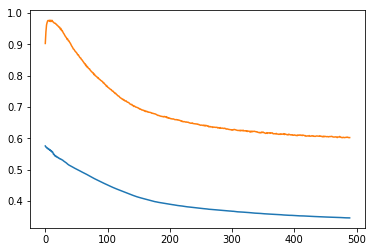

In [14]:
with open('../logs/simplewiki/mediawiki_model_autoencoder_1.log', 'rt') as f:
    lines = ''.join([l for l in f])
offset = 10
plt.plot([float(v) for v in re.findall(r'train.*mse_loss=(\d+\.\d+)', lines)][offset:])
plt.plot([float(v) for v in re.findall(r'dev.*mse_loss=(\d+\.\d+)', lines)][offset:])
plt.show()

In [17]:
sess.run(model._dataset_iterator.initializer, feed_dict={
    model._dataset_filenames: [
        '../data/simplewiki/simplewiki-20171103.autoencoder_1.train/examples.0000000000.tfrecords.gz'],
    model._dataset_limit: 10 })
page_tf_idfs, output_tf_idfs = sess.run((model._page_tf_idfs, model._output_tf_idfs), feed_dict = {
    model._training: False })

In [33]:
np.set_printoptions(precision = 4, suppress = True)

In [18]:
offset = 0
for i in range(page_tf_idfs.shape[1]):
    print('%0.4f, %0.4f, %0.4f' % (
        page_tf_idfs[offset, i], 
        output_tf_idfs[offset, i], 
        np.abs(output_tf_idfs[offset, i] - page_tf_idfs[offset, i])))

0.0000, 0.0073, 0.0073
0.0485, 0.0122, 0.0363
0.0096, 0.0060, 0.0036
0.0116, 0.0053, 0.0064
0.0124, 0.0054, 0.0070
0.0000, 0.0050, 0.0050
0.0000, 0.0041, 0.0041
0.0000, 0.0029, 0.0029
0.0000, 0.0028, 0.0028
0.0000, 0.0005, 0.0005
0.0000, 0.0036, 0.0036
0.0178, 0.0084, 0.0094
0.0000, 0.0039, 0.0039
0.0349, 0.0050, 0.0299
0.0000, 0.0045, 0.0045
0.0000, 0.0051, 0.0051
0.0000, 0.0042, 0.0042
0.0188, 0.0048, 0.0140
0.0000, 0.0033, 0.0033
0.0000, 0.0027, 0.0027
0.0000, 0.0032, 0.0032
0.0000, 0.0039, 0.0039
0.0000, 0.0057, 0.0057
0.0000, 0.0026, 0.0026
0.0000, 0.0037, 0.0037
0.0000, 0.0040, 0.0040
0.0000, 0.0067, 0.0067
0.0199, 0.0061, 0.0138
0.0000, 0.0003, 0.0003
0.0000, 0.0063, 0.0063
0.0000, 0.0020, 0.0020
0.0000, 0.0038, 0.0038
0.0000, 0.0046, 0.0046
0.0000, 0.0058, 0.0058
0.0000, 0.0028, 0.0028
0.0000, 0.0053, 0.0053
0.0000, 0.0027, 0.0027
0.0000, 0.0028, 0.0028
0.0000, 0.0018, 0.0018
0.0000, 0.0008, 0.0008
0.0000, 0.0053, 0.0053
0.0000, 0.0027, 0.0027
0.0000, 0.0061, 0.0061
0.0000, 0.0

0.0000, 0.0003, 0.0003
0.0000, 0.0004, 0.0004
0.0000, 0.0013, 0.0013
0.0000, -0.0008, 0.0008
0.0000, 0.0004, 0.0004
0.0000, -0.0001, 0.0001
0.0000, 0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, 0.0007, 0.0007
0.0000, 0.0005, 0.0005
0.0000, 0.0004, 0.0004
0.0000, -0.0002, 0.0002
0.0000, 0.0000, 0.0000
0.0000, 0.0006, 0.0006
0.0000, 0.0003, 0.0003
0.0000, 0.0003, 0.0003
0.0000, -0.0004, 0.0004
0.0000, 0.0002, 0.0002
0.0000, 0.0005, 0.0005
0.0000, 0.0012, 0.0012
0.0000, 0.0004, 0.0004
0.0000, 0.0004, 0.0004
0.0000, 0.0002, 0.0002
0.0000, 0.0005, 0.0005
0.0000, 0.0004, 0.0004
0.0000, 0.0000, 0.0000
0.0000, 0.0003, 0.0003
0.0000, 0.0004, 0.0004
0.0000, 0.0002, 0.0002
0.0000, 0.0008, 0.0008
0.0000, 0.0013, 0.0013
0.0000, 0.0005, 0.0005
0.0000, 0.0005, 0.0005
0.0000, 0.0005, 0.0005
0.0000, 0.0005, 0.0005
0.0000, 0.0006, 0.0006
0.0000, 0.0005, 0.0005
0.0000, 0.0005, 0.0005
0.0000, 0.0004, 0.0004
0.0000, 0.0004, 0.0004
0.0000, 0.0001, 0.0001
0.0000, 0.0002, 0.0002
0.0000, 0.0004, 0.0004
0.0000

0.0000, 0.0000, 0.0000
0.0000, -0.0000, 0.0000
0.0000, 0.0001, 0.0001
0.0000, 0.0007, 0.0007
0.0000, 0.0004, 0.0004
0.0000, 0.0001, 0.0001
0.0000, 0.0004, 0.0004
0.0000, -0.0001, 0.0001
0.0000, 0.0003, 0.0003
0.0000, 0.0002, 0.0002
0.0000, -0.0000, 0.0000
0.0000, 0.0001, 0.0001
0.0000, 0.0001, 0.0001
0.0000, 0.0065, 0.0065
0.0000, 0.0000, 0.0000
0.0000, 0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, -0.0003, 0.0003
0.0000, 0.0003, 0.0003
0.0000, 0.0002, 0.0002
0.0000, -0.0002, 0.0002
0.0000, -0.0000, 0.0000
0.0000, 0.0002, 0.0002
0.0000, 0.0001, 0.0001
0.0000, -0.0000, 0.0000
0.0000, 0.0001, 0.0001
0.0000, 0.0003, 0.0003
0.0000, 0.0002, 0.0002
0.0000, 0.0001, 0.0001
0.0000, 0.0000, 0.0000
0.0000, -0.0001, 0.0001
0.0000, -0.0000, 0.0000
0.0000, 0.0000, 0.0000
0.0000, 0.0000, 0.0000
0.0000, -0.0003, 0.0003
0.0000, -0.0001, 0.0001
0.0000, 0.0003, 0.0003
0.0000, 0.0002, 0.0002
0.0000, 0.0000, 0.0000
0.0000, -0.0002, 0.0002
0.0000, 0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, 0.0000, 0.00

0.0000, 0.0000, 0.0000
0.0000, 0.0002, 0.0002
0.0000, -0.0001, 0.0001
0.0000, 0.0000, 0.0000
0.0000, 0.0000, 0.0000
0.0000, 0.0024, 0.0024
0.0000, 0.0000, 0.0000
0.0000, -0.0001, 0.0001
0.0000, 0.0003, 0.0003
0.0000, 0.0003, 0.0003
0.0000, -0.0000, 0.0000
0.0000, 0.0002, 0.0002
0.0000, -0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, 0.0004, 0.0004
0.0000, -0.0003, 0.0003
0.0000, -0.0001, 0.0001
0.0000, -0.0000, 0.0000
0.0000, 0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, -0.0002, 0.0002
0.0000, 0.0001, 0.0001
0.0000, 0.0002, 0.0002
0.0000, 0.0001, 0.0001
0.0000, 0.0001, 0.0001
0.0000, 0.0004, 0.0004
0.0000, 0.0001, 0.0001
0.0000, -0.0002, 0.0002
0.0000, 0.0001, 0.0001
0.0000, -0.0000, 0.0000
0.0000, 0.0001, 0.0001
0.0000, 0.0002, 0.0002
0.0000, 0.0000, 0.0000
0.0000, 0.0000, 0.0000
0.0000, -0.0001, 0.0001
0.0000, -0.0001, 0.0001
0.0000, -0.0000, 0.0000
0.0000, 0.0001, 0.0001
0.0000, 0.0004, 0.0004
0.0000, -0.0001, 0.0001
0.0000, 0.0000, 

In [ ]:
# builder = tf.saved_model.builder.SavedModelBuilder('../models/simplewiki/topic_model_1_128')
# builder.add_meta_graph_and_variables(sess, ['training'])
# builder.save()

In [ ]:
# sess = reset_tf()
# tf.saved_model.loader.load(sess, ['training'], '../models/simplewiki/topic_model_1_256')
# print('loaded')

In [ ]:
# dataset_filenames = tf.get_default_graph().get_operation_by_name('dataset_filenames').outputs[0]
# embedding_layer = tf.get_default_graph().get_operation_by_name('input_embedding_layer/Relu').outputs[0]
# input_page_id = tf.get_default_graph().get_operation_by_name('input_page_id').outputs[0]
# input_para_id = tf.get_default_graph().get_operation_by_name('input_para_id').outputs[0]
# make_iterator = tf.get_default_graph().get_operation_by_name('MakeIterator')

In [ ]:
# def extract_embeddings(dataset_filename):
#     sess.run(make_iterator, feed_dict={
#         dataset_filenames: [dataset_filename]
#     })
    
#     progress = tqdm_notebook()
    
#     result = []
    
#     while True:
#         try:
#             (curr_input_page_id, 
#              curr_input_para_id, 
#              curr_embedding_layer) = sess.run((input_page_id, input_para_id, embedding_layer))
#         except tf.errors.OutOfRangeError:
#             break
#         for i in range(curr_input_page_id.shape[0]):
#             page_id = int(curr_input_page_id[i][0])
#             embedding = curr_embedding_layer[i].tolist()
#             result.append((page_id, embedding))
            
#         progress.update(curr_input_page_id.shape[0])
    
#     progress.close()
    
#     return result

In [ ]:
# all_embeddings = []

# all_embeddings.extend(extract_embeddings('../data/simplewiki/simplewiki-20171103.topic_model.30k.dev.tfrecords'))
# all_embeddings.extend(extract_embeddings('../data/simplewiki/simplewiki-20171103.topic_model.30k.test.tfrecords'))
# all_embeddings.extend(extract_embeddings('../data/simplewiki/simplewiki-20171103.topic_model.30k.train.tfrecords'))

# all_embeddings.sort()